In [1]:
# necessary imports
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
from openood.networks import ResNet18_32x32 # just a wrapper around the ResNet
import random

In [2]:
seed =123
random.seed(seed)  # Python random module
np.random.seed(seed)  # NumPy
torch.manual_seed(seed)  # PyTorch CPU
torch.cuda.manual_seed(seed)  # PyTorch GPU
torch.cuda.manual_seed_all(seed) 

In [3]:
# Data transformations (augmentation and normalization)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ]),
}

In [4]:
train_dir100 = './data/images_classic/cifar100/cifar100/train'
test_dir100 = './data/images_classic/cifar100/cifar100/test'
# Load train and test datasets
image_datasets100 = {
    'train': datasets.ImageFolder(train_dir100, transform=data_transforms['train']),
    'test': datasets.ImageFolder(test_dir100, transform=data_transforms['test'])
}

# Create DataLoaders
dataloaders100 = {
    'train': DataLoader(image_datasets100['train'], batch_size=256, shuffle=True, num_workers=4),
    'test': DataLoader(image_datasets100['test'], batch_size=256, shuffle=False, num_workers=4)
}

In [5]:
net = ResNet18_32x32(num_classes=100)
net.cuda()
net.eval()

ResNet18_32x32(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1,

In [6]:
def divide_train_test_datasets(train_dataset, test_dataset, num_classes, mode="subclass", superclasses=None):
    """
    Divides train and test datasets into subsets based on input class number and mode.

    Args:
        train_dataset (torch.utils.data.Dataset): The training dataset to divide.
        test_dataset (torch.utils.data.Dataset): The testing dataset to divide.
        num_classes (int): The number of classes to include in the first subset.
                           Must be a multiple of 5 in "superclass" mode.
        mode (str): "subclass" or "superclass" to determine division mode.
        superclasses (list of lists): Custom superclass mapping. Default is CIFAR-100 standard.

    Returns:
        train_subset1, train_subset2: Training subsets for the first and second groups of classes.
        test_subset1, test_subset2: Testing subsets for the first and second groups of classes.
    """
    # Default CIFAR-100 superclass mapping
    if superclasses is None:
        superclasses = [
            [4, 30, 55, 72, 95],   # Aquatic Mammals
            [1, 32, 67, 73, 91],   # Fish
            [54, 62, 70, 82, 92],  # Flowers
            [9, 10, 16, 28, 61],   # Food Containers
            [0, 51, 53, 57, 83],   # Fruit and Vegetables
            [22, 39, 40, 86, 87],  # Household Electrical Devices
            [5, 20, 25, 84, 94],   # Household Furniture
            [6, 7, 14, 18, 24],    # Insects
            [3, 42, 43, 88, 97],   # Large Carnivores
            [12, 17, 37, 68, 76],  # Large Man-made Outdoor Things
            [23, 33, 49, 60, 71],  # Large Natural Outdoor Scenes
            [15, 19, 21, 31, 38],  # Large Omnivores and Herbivores
            [34, 63, 64, 66, 75],  # Medium-sized Mammals
            [26, 45, 77, 79, 99],  # Non-insect Invertebrates
            [2, 11, 35, 46, 98],   # People
            [27, 29, 44, 78, 93],  # Reptiles
            [36, 50, 65, 74, 80],  # Small Mammals
            [8, 13, 48, 58, 90],   # Trees
            [41, 69, 81, 85, 89],  # Vehicles 1 (land)
            [47, 52, 56, 59, 96],  # Vehicles 2
        ]

    def divide_dataset(dataset, num_classes, mode):
        """Helper function to divide a single dataset."""
        if mode == "subclass":
            # Divide dataset by subclass labels
            subset1_indices = [i for i, (_, label) in enumerate(dataset.imgs) if label < num_classes]
            subset2_indices = [i for i, (_, label) in enumerate(dataset.imgs) if label >= num_classes]

        elif mode == "superclass":
            # Ensure num_classes is a multiple of 5
            if num_classes % 5 != 0:
                raise ValueError("num_classes must be a multiple of 5 in 'superclass' mode.")
            
            selected_superclasses = superclasses[:num_classes // 5]
            subset1_labels = [label for group in selected_superclasses for label in group]

            subset1_indices = [i for i, (_, label) in enumerate(dataset.imgs) if label in subset1_labels]
            subset2_indices = [i for i, (_, label) in enumerate(dataset.imgs) if label not in subset1_labels]
        else:
            raise ValueError("Invalid mode. Choose 'subclass' or 'superclass'.")

        subset1 = Subset(dataset, subset1_indices)
        subset2 = Subset(dataset, subset2_indices)
        return subset1, subset2

    # Divide training and testing datasets
    train_subset1, train_subset2 = divide_dataset(train_dataset, num_classes, mode)
    test_subset1, test_subset2 = divide_dataset(test_dataset, num_classes, mode)

    return train_subset1, train_subset2, test_subset1, test_subset2

In [16]:
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
def train_resnet18(epochs, model, train_loader, test_loader, device='cuda'):
    """
    Trains and evaluates a ResNet-18 model on a given dataset.

    Args:
        epochs (int): Number of training epochs.
        model (torch.nn.Module): ResNet-18 model.
        train_loader (DataLoader): DataLoader for the training dataset.
        test_loader (DataLoader): DataLoader for the testing dataset.
        device (str): Device to use for training ('cuda' or 'cpu').

    Returns:
        dict: Dictionary containing training and testing accuracy and losses per epoch.
        torch.nn.Module: Best performing model (based on test accuracy).
    """
    # Set the device
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Define loss function, optimizer, and scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    # Metrics storage
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    best_accuracy = 0.0
    best_model = None  # To store the best model state

    # Training and evaluation loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = 100.0 * correct / total
        train_loss /= len(train_loader)

        # Testing phase
        model.eval()
        test_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        test_acc = 100.0 * correct / total
        test_loss /= len(test_loader)

        # Scheduler step
        scheduler.step()

        # Save metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        # Save best model in memory
        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_model = model.state_dict()  # Save the state dict of the best model

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

    print(f"Best Test Accuracy: {best_accuracy:.2f}%")

    # Load the best model into memory
    model.load_state_dict(best_model)
def evaluate_model(model, test_loader,device='cuda'):
    """
    Evaluates a model on a test dataset.
    
    Args:
        model (torch.nn.Module): The model to evaluate.
        test_loader (DataLoader): DataLoader for the testing dataset.
        criterion (torch.nn.Module): Loss function.
        device (torch.device): Device to evaluate on ('cpu' or 'cuda').
    """
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Update metrics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Test Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_acc:.4f}")


In [9]:
# Example usage
num_classes = 50  # Number of classes in the first subset
train_subset1, train_subset2, test_subset1, test_subset2 = divide_train_test_datasets(
    image_datasets100['train'], 
    image_datasets100['test'], 
    num_classes
)

# Create DataLoaders for training and testing subsets
train_loader1 = DataLoader(train_subset1, batch_size=64, shuffle=True, num_workers=4)
train_loader2 = DataLoader(train_subset2, batch_size=64, shuffle=True, num_workers=4)
test_loader1 = DataLoader(test_subset1, batch_size=64, shuffle=False, num_workers=4)
test_loader2 = DataLoader(test_subset2, batch_size=64, shuffle=False, num_workers=4)

In [11]:
train_resnet18(epochs=20, model=net, train_loader=train_loader1, test_loader=test_loader1)

Epoch 1/20
Train Loss: 3.3010, Train Accuracy: 16.30%
Test Loss: 3.0993, Test Accuracy: 22.12%
Epoch 2/20
Train Loss: 2.6770, Train Accuracy: 28.78%
Test Loss: 2.7242, Test Accuracy: 29.26%
Epoch 3/20
Train Loss: 2.2735, Train Accuracy: 37.50%
Test Loss: 2.1715, Test Accuracy: 41.14%
Epoch 4/20
Train Loss: 1.9608, Train Accuracy: 44.76%
Test Loss: 1.9852, Test Accuracy: 45.82%
Epoch 5/20
Train Loss: 1.7183, Train Accuracy: 50.51%
Test Loss: 1.7580, Test Accuracy: 50.14%
Epoch 6/20
Train Loss: 1.5204, Train Accuracy: 55.48%
Test Loss: 1.6916, Test Accuracy: 53.12%
Epoch 7/20
Train Loss: 1.3626, Train Accuracy: 59.47%
Test Loss: 1.5516, Test Accuracy: 55.76%
Epoch 8/20
Train Loss: 1.2173, Train Accuracy: 63.66%
Test Loss: 1.4501, Test Accuracy: 58.28%
Epoch 9/20
Train Loss: 1.0969, Train Accuracy: 67.10%
Test Loss: 1.2546, Test Accuracy: 63.54%
Epoch 10/20
Train Loss: 0.9709, Train Accuracy: 70.36%
Test Loss: 1.2019, Test Accuracy: 65.24%
Epoch 11/20
Train Loss: 0.8663, Train Accuracy: 7

In [21]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc,roc_curve,accuracy_score
import matplotlib.pyplot as plt

In [19]:
# Compute scores for ID (subset1) and OOD (subset2)
id_scores = compute_softmax_scores(net, test_loader1, device="cuda")  # Subset1 as ID
ood_scores = compute_softmax_scores(net, test_loader2, device="cuda")  # Subset2 as OOD

In [20]:
id_scores,ood_scores

([0.99138206,
  0.8051591,
  0.999629,
  0.9647173,
  0.99980015,
  0.95430887,
  0.9993025,
  0.99515355,
  0.9990792,
  0.8678916,
  0.9325869,
  0.99934536,
  0.9092027,
  0.99998164,
  0.9993005,
  0.9985061,
  0.99350303,
  0.99995327,
  0.99995506,
  0.9999827,
  0.9998418,
  0.9966788,
  0.9992386,
  0.99998343,
  0.4519166,
  0.9997757,
  0.99963486,
  0.99993455,
  0.999943,
  0.9988176,
  0.9995357,
  0.9999739,
  0.9999757,
  0.9543092,
  0.9799702,
  0.99969184,
  0.9907204,
  0.4441598,
  0.9992887,
  0.99772125,
  0.9979601,
  0.84558535,
  0.9995115,
  0.9996773,
  0.99968827,
  0.9999529,
  0.999997,
  0.79809463,
  0.99813867,
  0.9989297,
  0.8864626,
  0.4455791,
  0.5704706,
  0.982142,
  0.9999943,
  0.56959456,
  0.9972976,
  0.9998772,
  0.9993699,
  0.99997056,
  0.9987173,
  0.9998647,
  0.9996308,
  0.999869,
  0.9964904,
  0.9999964,
  0.9355576,
  0.98952824,
  0.57740325,
  0.999967,
  0.62949747,
  0.99980766,
  0.9999827,
  0.93697166,
  0.98349184,
  0.9

In [25]:
class Softmax_OODDetector:
    def __init__(self, model, device="cuda"):
        self.model = model
        self.device = device

    def compute_softmax_scores(self, loader):
        """
        Computes the maximum softmax scores for a given dataset.
        
        Args:
            loader (DataLoader): DataLoader for the dataset to evaluate.
        
        Returns:
            List[float]: List of maximum softmax scores for all samples.
        """
        self.model.eval()
        scores = []
        
        with torch.no_grad():
            for inputs, _ in tqdm(loader, desc="Computing Softmax Scores", leave=False):
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                softmax_scores = F.softmax(outputs, dim=1)
                max_scores = softmax_scores.max(dim=1).values  # Get max softmax for each sample
                scores.extend(max_scores.cpu().numpy())
        
        return scores

    def calculate_fpr_tpr(self, id_scores, ood_scores):
        """
        Calculate FPR and TPR for different thresholds based on ID and OOD scores.

        Args:
        - id_scores (torch.Tensor): Scores for in-distribution samples.
        - ood_scores (torch.Tensor): Scores for out-of-distribution samples.

        Returns:
        - fpr (np.array): False Positive Rate for different thresholds.
        - tpr (np.array): True Positive Rate for different thresholds.
        """
        id_labels = np.zeros_like(id_scores)  # ID samples
        ood_labels = np.ones_like(ood_scores)  # OOD samples

        # Concatenate the ID and OOD scores and labels
        scores = np.concatenate([id_scores, ood_scores])
        labels = np.concatenate([id_labels, ood_labels])

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(labels, -scores)
        return fpr, tpr

    def evaluate(self, id_loader, ood_loader):
        """
        Evaluate OOD detection performance by calculating FPR at specific TPR levels.

        Args:
        - id_loader (DataLoader): DataLoader for the in-distribution dataset (test data).
        - ood_loader (DataLoader): DataLoader for the out-of-distribution dataset (test data).

        Returns:
        - fpr_at_tpr_dict (dict): A dictionary mapping TPR values to corresponding FPR values.
        """
        # Extract ID and OOD scores
        id_scores = self.compute_softmax_scores(id_loader)
        ood_scores = self.compute_softmax_scores(ood_loader)

        # Calculate FPR and TPR for different thresholds
        fpr, tpr = self.calculate_fpr_tpr(np.array(id_scores), np.array(ood_scores))

        # Define TPR thresholds at which we want to find the corresponding FPR values
        tpr_thresholds = np.arange(0.05, 1.0, 0.1)  # TPR levels: 0.05, 0.15, 0.25, ..., 0.95
        fpr_at_tpr = []

        # Interpolate FPR values at the desired TPR thresholds
        for threshold in tpr_thresholds:
            idx = np.searchsorted(tpr, threshold)
            fpr_at_tpr.append(fpr[idx])

        # Store FPR values at different TPR thresholds in a dictionary
        fpr_at_tpr_dict = dict(zip(tpr_thresholds, fpr_at_tpr))

        # Print the FPR at each TPR threshold
        for tpr_val, fpr_val in fpr_at_tpr_dict.items():
            print(f"FPR at TPR={tpr_val:.2f}: {fpr_val:.4f}")

        # Plot ROC curve
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

        return fpr_at_tpr_dict

FPR at TPR=0.05: 0.0174
FPR at TPR=0.15: 0.0606
FPR at TPR=0.25: 0.1046
FPR at TPR=0.35: 0.1554
FPR at TPR=0.45: 0.2232
FPR at TPR=0.55: 0.2924
FPR at TPR=0.65: 0.3594
FPR at TPR=0.75: 0.4322
FPR at TPR=0.85: 0.5580
FPR at TPR=0.95: 0.7776


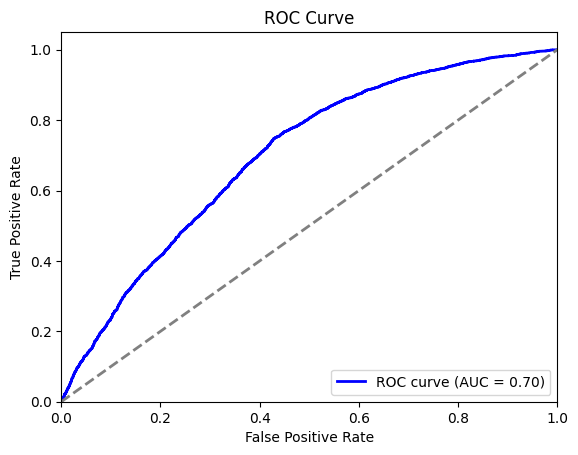

In [24]:
ood_detector = Softmax_OODDetector(net)
fpr_at_tpr_dict = ood_detector.evaluate(test_loader1, test_loader2)

In [26]:
import faiss


In [27]:

# Normalizer function to ensure unit norm
normalizer = lambda x: x / np.linalg.norm(x, axis=-1, keepdims=True) + 1e-10


class KNNPostprocessor():
    def __init__(self, K):
        self.K = K
        self.activation_log = None

    def setup(self, net: nn.Module, id_loader_dict, return_exit1=False, return_exit2=False):
        activation_log = []
        net.eval()
        with torch.no_grad():
            for batch in tqdm(id_loader_dict, desc='Setup: ', position=0, leave=True):
                data = batch[0].cuda()
                data = data.float()
                if return_exit1:
                    _, feature = net(data, return_exit1=True)
                    activation_log.append(normalizer(feature.data.cpu().numpy()))
                elif return_exit2:
                    _, feature = net(data, return_exit2=True)
                    activation_log.append(normalizer(feature.data.cpu().numpy()))
                else:
                    _, feature = net(data,return_feature=True)
                    activation_log.append(normalizer(feature.data.cpu().numpy()))

        self.activation_log = np.concatenate(activation_log, axis=0)
        self.index = faiss.IndexFlatL2(feature.shape[1])
        self.index.add(self.activation_log)

    def detect_ood(self, net: nn.Module, ood_loader, return_exit1, return_exit2):
        ood_scores = []
        net.eval()

        for batch in tqdm(ood_loader, desc='Processing OOD data', position=0, leave=True):
            data = batch[0].cuda()

            if return_exit1:
                _, feature = net(data, return_exit1=True)
            elif return_exit2:
                _, feature = net(data, return_exit2=True)
            else:
                _, feature = net(data,return_feature=True)

            feature_normed = normalizer(feature.data.cpu().numpy())
            D, _ = self.index.search(feature_normed, self.K)
            kth_dist = -D[:, -1]
            ood_scores.append(torch.from_numpy(kth_dist))

        ood_scores = torch.cat(ood_scores, dim=0)
        return ood_scores

    def calculate_fpr_tpr(self, id_scores, ood_scores):
        """
        Calculate FPR and TPR for different thresholds based on ID and OOD scores.

        Args:
        - id_scores (torch.Tensor): Scores for in-distribution samples.
        - ood_scores (torch.Tensor): Scores for out-of-distribution samples.

        Returns:
        - fpr (np.array): False Positive Rate for different thresholds.
        - tpr (np.array): True Positive Rate for different thresholds.
        """
        # For ID samples, the label is 0 (not OOD)
        id_labels = np.zeros_like(id_scores)
        # For OOD samples, the label is 1 (OOD)
        ood_labels = np.ones_like(ood_scores)

        # Concatenate the ID and OOD scores and labels
        scores = np.concatenate([id_scores, ood_scores])
        labels = np.concatenate([id_labels, ood_labels])

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(labels, -scores)
        return fpr, tpr

    def evaluate(self, id_loader, ood_loader, net, return_exit1=False, return_exit2=False):
        """
        Evaluate OOD detection performance by calculating FPR at specific TPR levels.

        Args:
        - id_loader (DataLoader): DataLoader for the in-distribution dataset (test data).
        - ood_loader (DataLoader): DataLoader for the out-of-distribution dataset (test data).
        - net (nn.Module): The neural network model used for feature extraction.

        Returns:
        - fpr_at_tpr_dict (dict): A dictionary mapping TPR values to corresponding FPR values.
        """
        # Extract ID and OOD scores
        self.id_scores = self.detect_ood(net, id_loader, return_exit1, return_exit2)
        self.ood_scores = self.detect_ood(net, ood_loader, return_exit1, return_exit2)

        # Calculate FPR and TPR for different thresholds
        fpr, tpr = self.calculate_fpr_tpr(self.id_scores.numpy(), self.ood_scores.numpy())

        # Define TPR thresholds at which we want to find the corresponding FPR values
        tpr_thresholds = np.arange(0.05, 1.0, 0.1)  # TPR levels: 0.05, 0.15, 0.25, ..., 0.95
        fpr_at_tpr = []

        # Interpolate FPR values at the desired TPR thresholds
        for threshold in tpr_thresholds:
            # Find the index where TPR is closest to the desired threshold
            idx = np.searchsorted(tpr, threshold)
            fpr_at_tpr.append(fpr[idx])

        # Store FPR values at different TPR thresholds in a dictionary
        fpr_at_tpr_dict = dict(zip(tpr_thresholds, fpr_at_tpr))

        # Print the FPR at each TPR threshold
        for tpr_val, fpr_val in fpr_at_tpr_dict.items():
            print(f"FPR at TPR={tpr_val:.2f}: {fpr_val:.4f}")

        # Plot ROC curve
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

        return fpr_at_tpr_dict

Processing OOD data: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.51it/s]

FPR at TPR=0.05: 0.0216
FPR at TPR=0.15: 0.0722
FPR at TPR=0.25: 0.1166
FPR at TPR=0.35: 0.1676
FPR at TPR=0.45: 0.2332
FPR at TPR=0.55: 0.2994
FPR at TPR=0.65: 0.3696
FPR at TPR=0.75: 0.4614
FPR at TPR=0.85: 0.5882
FPR at TPR=0.95: 0.7936


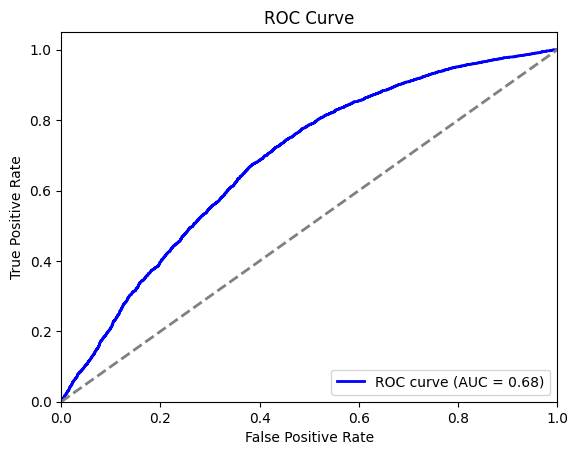

FPR at TPR=0.05: 0.0216
FPR at TPR=0.15: 0.0722
FPR at TPR=0.25: 0.1166
FPR at TPR=0.35: 0.1676
FPR at TPR=0.45: 0.2332
FPR at TPR=0.55: 0.2994
FPR at TPR=0.65: 0.3696
FPR at TPR=0.75: 0.4614
FPR at TPR=0.85: 0.5882
FPR at TPR=0.95: 0.7936


In [29]:
k50 = KNNPostprocessor(50)
# Setup Faiss index with in-distribution training data
k50.setup(net,train_loader1 )
# Evaluate OOD detection performance and print FPR at specific TPR thresholds
fpr_at_tpr_dict = k50.evaluate(test_loader1, test_loader2, net)
# Print the FPR at TPR values 0.05, 0.15, ..., 0.95
for tpr_val, fpr_val in fpr_at_tpr_dict.items():
    print(f"FPR at TPR={tpr_val:.2f}: {fpr_val:.4f}")

# Loop

In [ ]:
subclass5 = ResNet18_32x32(num_classes=100)
subclass5.cuda()
subclass5.eval()

num_classes = 5  # Number of classes in the first subset
train_subset1, train_subset2, test_subset1, test_subset2 = divide_train_test_datasets(
    image_datasets100['train'], 
    image_datasets100['test'], 
    num_classes
)

# Create DataLoaders for training and testing subsets
train_loader1 = DataLoader(train_subset1, batch_size=64, shuffle=True, num_workers=4)
train_loader2 = DataLoader(train_subset2, batch_size=64, shuffle=True, num_workers=4)
test_loader1 = DataLoader(test_subset1, batch_size=64, shuffle=False, num_workers=4)
test_loader2 = DataLoader(test_subset2, batch_size=64, shuffle=False, num_workers=4)

train_resnet18(epochs=20, model=subclass5, train_loader=train_loader1, test_loader=test_loader1)

torch.save(subclass5.state_dict(), 'subclass5.pth')

ood_detector = Softmax_OODDetector(subclass5)
softmax_dict_subclass5 = ood_detector.evaluate(test_loader1, test_loader2)
k50 = KNNPostprocessor(50)
# Setup Faiss index with in-distribution training data
k50.setup(subclass5,train_loader1 )
# Evaluate OOD detection performance and print FPR at specific TPR thresholds
knn_dict_subclass5 = k50.evaluate(test_loader1, test_loader2, subclass5)
# Print the FPR at TPR values 0.05, 0.15, ..., 0.95



In [32]:

# Function to run the experiment
def run_experiment(image_datasets100, num_epochs=20, batch_size=64, num_workers=4):
    softmax_results_subclass = {}
    knn_results_subclass = {}
    softmax_results_superclass = {}
    knn_results_superclass = {}
    # Start from 5 and increase by 10 until 95, then switch to superclass mode
    for num_classes in range(5, 96, 10):
        # Subclass mode
        print(f"Running experiment with {num_classes} classes (Subclass Mode)")

        subclass_model = ResNet18_32x32(num_classes=100)  # Modify based on ResNet18 definition
        subclass_model.cuda()
        subclass_model.eval()

        train_subset1, train_subset2, test_subset1, test_subset2 = divide_train_test_datasets(
            image_datasets100['train'], 
            image_datasets100['test'], 
            num_classes
        )

        # Create DataLoaders
        train_loader1 = DataLoader(train_subset1, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        train_loader2 = DataLoader(train_subset2, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        test_loader1 = DataLoader(test_subset1, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        test_loader2 = DataLoader(test_subset2, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        # Train the model
        train_resnet18(epochs=num_epochs, model=subclass_model, train_loader=train_loader1, test_loader=test_loader1)
        
        # Save the trained model
        torch.save(subclass_model.state_dict(), f'subclass_{num_classes}.pth')

        # Evaluate Softmax OOD detection performance
        ood_detector = Softmax_OODDetector(subclass_model)
        softmax_dict = ood_detector.evaluate(test_loader1, test_loader2)
        softmax_results_subclass[num_classes] = softmax_dict

        # Evaluate KNN OOD detection performance
        k50 = KNNPostprocessor(50)
        k50.setup(subclass_model, train_loader1)
        knn_dict = k50.evaluate(test_loader1, test_loader2, subclass_model)
        knn_results_subclass[num_classes] = knn_dict

        # Switch to Superclass Mode once num_classes reaches 95
        if num_classes == 95:
            break

    # After subclass mode, switch to superclass mode and repeat for 5, 10, ..., 95
    for num_classes in range(5, 96, 10):
        print(f"Running experiment with {num_classes} classes (Superclass Mode)")

        # Update the model for superclass mode (modify number of classes per superclass)
        superclass_model = ResNet18_32x32(num_classes=100)  # Modify based on ResNet18 definition
        superclass_model.cuda()
        superclass_model.eval()

        train_subset1, train_subset2, test_subset1, test_subset2 = divide_train_test_datasets(
            image_datasets100['train'], 
            image_datasets100['test'], 
            num_classes,
            mode = "superclass"
        )

        # Create DataLoaders
        train_loader1 = DataLoader(train_subset1, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        train_loader2 = DataLoader(train_subset2, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        test_loader1 = DataLoader(test_subset1, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        test_loader2 = DataLoader(test_subset2, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        # Train the model
        train_resnet18(epochs=num_epochs, model=superclass_model, train_loader=train_loader1, test_loader=test_loader1)
        
        # Save the trained model
        torch.save(superclass_model.state_dict(), f'superclass_{num_classes}.pth')

        # Evaluate Softmax OOD detection performance
        ood_detector = Softmax_OODDetector(superclass_model)
        softmax_dict = ood_detector.evaluate(test_loader1, test_loader2)
        softmax_results_superclass[num_classes] = softmax_dict

        # Evaluate KNN OOD detection performance
        k50 = KNNPostprocessor(50)
        k50.setup(superclass_model, train_loader1)
        knn_dict = k50.evaluate(test_loader1, test_loader2, superclass_model)
        knn_results_superclass[num_classes] = knn_dict

    return softmax_results_subclass, knn_results_subclass, softmax_results_superclass, knn_results_superclass





Running experiment with 5 classes (Subclass Mode)
Epoch 1/20
Train Loss: 1.3775, Train Accuracy: 50.68%
Test Loss: 1.4581, Test Accuracy: 52.40%
Epoch 2/20
Train Loss: 1.1438, Train Accuracy: 57.04%
Test Loss: 1.5541, Test Accuracy: 55.20%
Epoch 3/20
Train Loss: 1.0135, Train Accuracy: 60.52%
Test Loss: 0.7330, Test Accuracy: 71.20%
Epoch 4/20
Train Loss: 0.8492, Train Accuracy: 67.88%
Test Loss: 0.8772, Test Accuracy: 65.40%
Epoch 5/20
Train Loss: 0.8235, Train Accuracy: 68.64%
Test Loss: 0.8535, Test Accuracy: 68.60%
Epoch 6/20
Train Loss: 0.8512, Train Accuracy: 68.24%
Test Loss: 0.9544, Test Accuracy: 65.40%
Epoch 7/20
Train Loss: 0.8786, Train Accuracy: 65.20%
Test Loss: 0.7129, Test Accuracy: 73.00%
Epoch 8/20
Train Loss: 0.7027, Train Accuracy: 74.04%
Test Loss: 0.8133, Test Accuracy: 69.60%
Epoch 9/20
Train Loss: 0.8020, Train Accuracy: 69.68%
Test Loss: 0.7479, Test Accuracy: 71.60%
Epoch 10/20
Train Loss: 0.6661, Train Accuracy: 73.40%
Test Loss: 0.6739, Test Accuracy: 72.20%

FPR at TPR=0.05: 0.0180
FPR at TPR=0.15: 0.0520
FPR at TPR=0.25: 0.1020
FPR at TPR=0.35: 0.1420
FPR at TPR=0.45: 0.2120
FPR at TPR=0.55: 0.2620
FPR at TPR=0.65: 0.3580
FPR at TPR=0.75: 0.4660
FPR at TPR=0.85: 0.5780
FPR at TPR=0.95: 0.7400


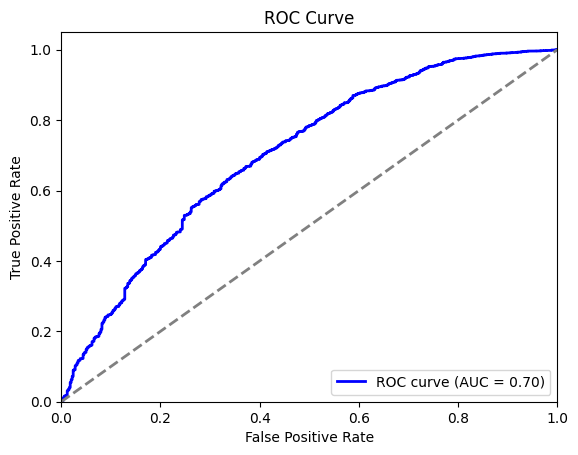

Processing OOD data: 100%|███████████████████████████████████████████████████████████| 149/149 [00:19<00:00,  7.54it/s]

FPR at TPR=0.05: 0.0060
FPR at TPR=0.15: 0.0500
FPR at TPR=0.25: 0.0920
FPR at TPR=0.35: 0.1400
FPR at TPR=0.45: 0.1900
FPR at TPR=0.55: 0.2560
FPR at TPR=0.65: 0.3420
FPR at TPR=0.75: 0.4340
FPR at TPR=0.85: 0.6160
FPR at TPR=0.95: 0.8020


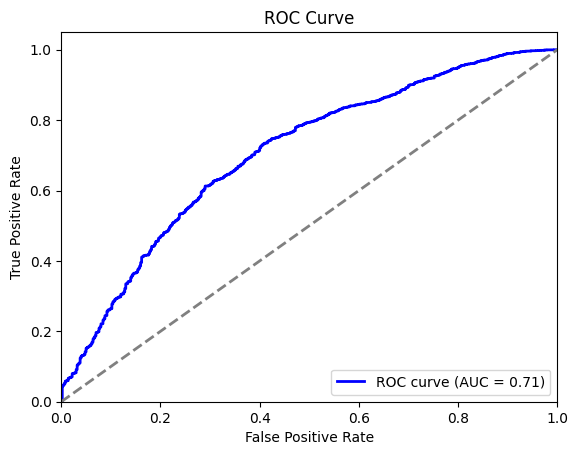

Running experiment with 15 classes (Subclass Mode)
Epoch 1/20
Train Loss: 2.4137, Train Accuracy: 25.24%
Test Loss: 1.9306, Test Accuracy: 37.73%
Epoch 2/20
Train Loss: 1.9244, Train Accuracy: 38.52%
Test Loss: 1.7618, Test Accuracy: 45.00%
Epoch 3/20
Train Loss: 1.7301, Train Accuracy: 44.17%
Test Loss: 1.7033, Test Accuracy: 46.67%
Epoch 4/20
Train Loss: 1.5337, Train Accuracy: 49.91%
Test Loss: 2.6037, Test Accuracy: 34.00%
Epoch 5/20
Train Loss: 1.4475, Train Accuracy: 53.03%
Test Loss: 1.4356, Test Accuracy: 55.27%
Epoch 6/20
Train Loss: 1.2883, Train Accuracy: 57.48%
Test Loss: 1.4209, Test Accuracy: 58.20%
Epoch 7/20
Train Loss: 1.1669, Train Accuracy: 61.00%
Test Loss: 1.4197, Test Accuracy: 56.20%
Epoch 8/20
Train Loss: 1.0643, Train Accuracy: 64.96%
Test Loss: 1.1946, Test Accuracy: 62.07%
Epoch 9/20
Train Loss: 0.9268, Train Accuracy: 69.19%
Test Loss: 1.0474, Test Accuracy: 66.40%
Epoch 10/20
Train Loss: 0.8555, Train Accuracy: 71.44%
Test Loss: 1.2613, Test Accuracy: 63.13

FPR at TPR=0.05: 0.0100
FPR at TPR=0.15: 0.0507
FPR at TPR=0.25: 0.0953
FPR at TPR=0.35: 0.1433
FPR at TPR=0.45: 0.1940
FPR at TPR=0.55: 0.2560
FPR at TPR=0.65: 0.3233
FPR at TPR=0.75: 0.4120
FPR at TPR=0.85: 0.5213
FPR at TPR=0.95: 0.6993


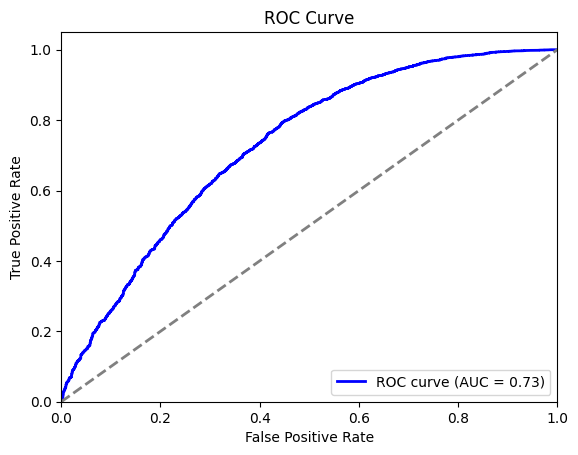

Processing OOD data: 100%|███████████████████████████████████████████████████████████| 133/133 [00:38<00:00,  3.45it/s]

FPR at TPR=0.05: 0.0067
FPR at TPR=0.15: 0.0387
FPR at TPR=0.25: 0.0820
FPR at TPR=0.35: 0.1240
FPR at TPR=0.45: 0.1640
FPR at TPR=0.55: 0.2213
FPR at TPR=0.65: 0.2900
FPR at TPR=0.75: 0.3700
FPR at TPR=0.85: 0.4980
FPR at TPR=0.95: 0.7133


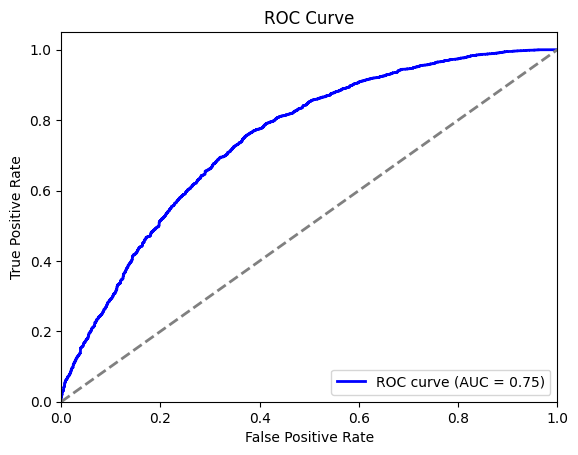

Running experiment with 25 classes (Subclass Mode)
Epoch 1/20
Train Loss: 2.6955, Train Accuracy: 24.05%
Test Loss: 2.3561, Test Accuracy: 30.96%
Epoch 2/20
Train Loss: 2.1936, Train Accuracy: 35.19%
Test Loss: 1.9792, Test Accuracy: 40.44%
Epoch 3/20
Train Loss: 1.8910, Train Accuracy: 42.83%
Test Loss: 2.6140, Test Accuracy: 35.68%
Epoch 4/20
Train Loss: 1.6563, Train Accuracy: 49.44%
Test Loss: 1.6945, Test Accuracy: 52.36%
Epoch 5/20
Train Loss: 1.4390, Train Accuracy: 55.40%
Test Loss: 1.5927, Test Accuracy: 54.48%
Epoch 6/20
Train Loss: 1.2692, Train Accuracy: 60.54%
Test Loss: 1.2302, Test Accuracy: 61.92%
Epoch 7/20
Train Loss: 1.1415, Train Accuracy: 64.21%
Test Loss: 1.4189, Test Accuracy: 58.64%
Epoch 8/20
Train Loss: 1.0022, Train Accuracy: 68.10%
Test Loss: 1.2584, Test Accuracy: 63.24%
Epoch 9/20
Train Loss: 0.9034, Train Accuracy: 71.21%
Test Loss: 1.0861, Test Accuracy: 66.76%
Epoch 10/20
Train Loss: 0.8178, Train Accuracy: 74.06%
Test Loss: 1.0174, Test Accuracy: 68.88

FPR at TPR=0.05: 0.0096
FPR at TPR=0.15: 0.0424
FPR at TPR=0.25: 0.0780
FPR at TPR=0.35: 0.1252
FPR at TPR=0.45: 0.1736
FPR at TPR=0.55: 0.2264
FPR at TPR=0.65: 0.2848
FPR at TPR=0.75: 0.3592
FPR at TPR=0.85: 0.4640
FPR at TPR=0.95: 0.6464


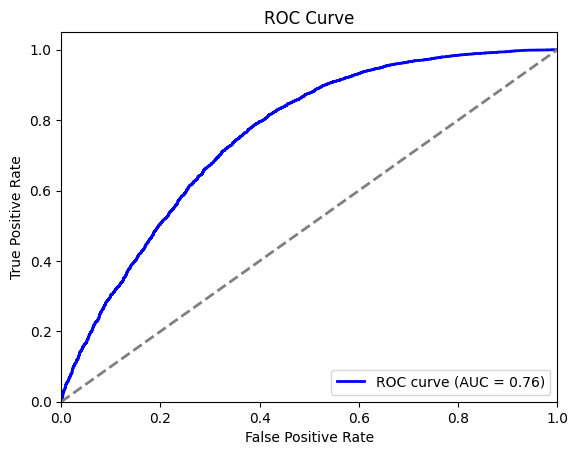

Processing OOD data: 100%|███████████████████████████████████████████████████████████| 118/118 [00:46<00:00,  2.52it/s]

FPR at TPR=0.05: 0.0136
FPR at TPR=0.15: 0.0444
FPR at TPR=0.25: 0.0828
FPR at TPR=0.35: 0.1240
FPR at TPR=0.45: 0.1612
FPR at TPR=0.55: 0.2144
FPR at TPR=0.65: 0.2744
FPR at TPR=0.75: 0.3640
FPR at TPR=0.85: 0.4920
FPR at TPR=0.95: 0.6972


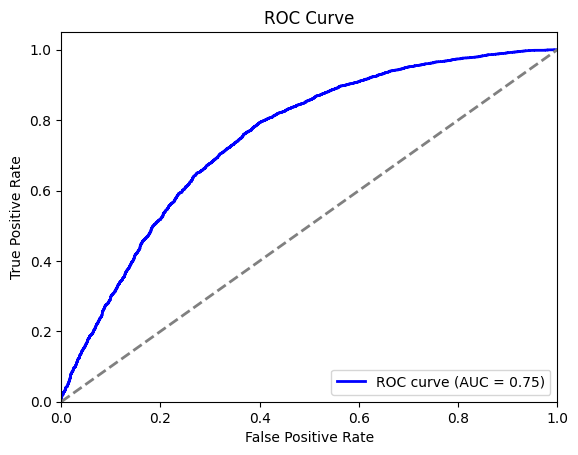

Running experiment with 35 classes (Subclass Mode)
Epoch 1/20
Train Loss: 3.0066, Train Accuracy: 19.58%
Test Loss: 2.5735, Test Accuracy: 28.66%
Epoch 2/20
Train Loss: 2.4316, Train Accuracy: 32.18%
Test Loss: 2.2851, Test Accuracy: 36.54%
Epoch 3/20
Train Loss: 2.0677, Train Accuracy: 40.94%
Test Loss: 1.9390, Test Accuracy: 44.03%
Epoch 4/20
Train Loss: 1.7762, Train Accuracy: 48.00%
Test Loss: 2.0269, Test Accuracy: 45.11%
Epoch 5/20
Train Loss: 1.5391, Train Accuracy: 54.41%
Test Loss: 1.6108, Test Accuracy: 55.43%
Epoch 6/20
Train Loss: 1.3599, Train Accuracy: 59.22%
Test Loss: 1.4038, Test Accuracy: 58.74%
Epoch 7/20
Train Loss: 1.2139, Train Accuracy: 63.17%
Test Loss: 1.5003, Test Accuracy: 58.00%
Epoch 8/20
Train Loss: 1.0734, Train Accuracy: 67.23%
Test Loss: 1.3807, Test Accuracy: 61.71%
Epoch 9/20
Train Loss: 0.9580, Train Accuracy: 70.42%
Test Loss: 1.1970, Test Accuracy: 65.63%
Epoch 10/20
Train Loss: 0.8600, Train Accuracy: 73.26%
Test Loss: 1.0913, Test Accuracy: 68.06

FPR at TPR=0.05: 0.0117
FPR at TPR=0.15: 0.0491
FPR at TPR=0.25: 0.0846
FPR at TPR=0.35: 0.1351
FPR at TPR=0.45: 0.1871
FPR at TPR=0.55: 0.2489
FPR at TPR=0.65: 0.3074
FPR at TPR=0.75: 0.3891
FPR at TPR=0.85: 0.4971
FPR at TPR=0.95: 0.6869


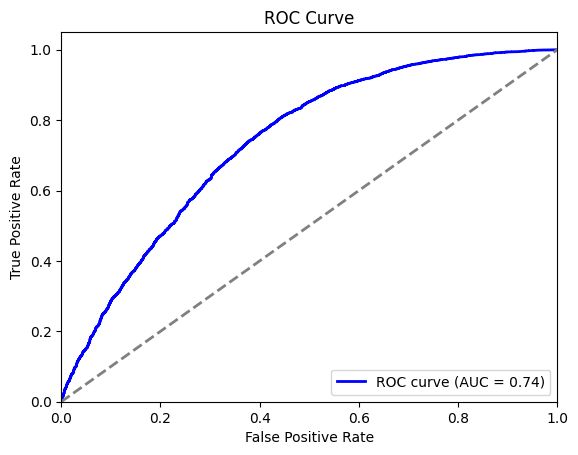

Processing OOD data: 100%|███████████████████████████████████████████████████████████| 102/102 [00:48<00:00,  2.12it/s]

FPR at TPR=0.05: 0.0166
FPR at TPR=0.15: 0.0540
FPR at TPR=0.25: 0.0871
FPR at TPR=0.35: 0.1329
FPR at TPR=0.45: 0.1817
FPR at TPR=0.55: 0.2440
FPR at TPR=0.65: 0.3103
FPR at TPR=0.75: 0.3969
FPR at TPR=0.85: 0.5069
FPR at TPR=0.95: 0.7163


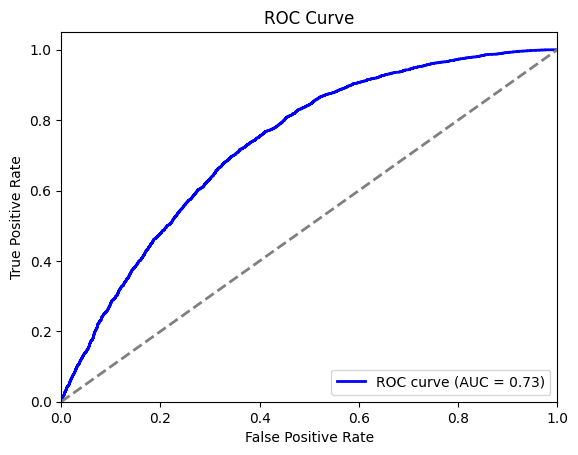

Running experiment with 45 classes (Subclass Mode)
Epoch 1/20
Train Loss: 3.2486, Train Accuracy: 16.55%
Test Loss: 3.0152, Test Accuracy: 21.82%
Epoch 2/20
Train Loss: 2.6677, Train Accuracy: 28.47%
Test Loss: 2.5275, Test Accuracy: 32.89%
Epoch 3/20
Train Loss: 2.2846, Train Accuracy: 37.27%
Test Loss: 2.2365, Test Accuracy: 38.18%
Epoch 4/20
Train Loss: 1.9433, Train Accuracy: 44.75%
Test Loss: 1.9730, Test Accuracy: 46.22%
Epoch 5/20
Train Loss: 1.6933, Train Accuracy: 51.17%
Test Loss: 1.6999, Test Accuracy: 51.78%
Epoch 6/20
Train Loss: 1.4820, Train Accuracy: 56.64%
Test Loss: 1.6572, Test Accuracy: 53.60%
Epoch 7/20
Train Loss: 1.3272, Train Accuracy: 61.00%
Test Loss: 1.4464, Test Accuracy: 59.18%
Epoch 8/20
Train Loss: 1.1757, Train Accuracy: 64.64%
Test Loss: 1.4114, Test Accuracy: 60.22%
Epoch 9/20
Train Loss: 1.0475, Train Accuracy: 68.65%
Test Loss: 1.2537, Test Accuracy: 65.07%
Epoch 10/20
Train Loss: 0.9505, Train Accuracy: 70.64%
Test Loss: 1.3556, Test Accuracy: 61.96

FPR at TPR=0.05: 0.0131
FPR at TPR=0.15: 0.0480
FPR at TPR=0.25: 0.0922
FPR at TPR=0.35: 0.1498
FPR at TPR=0.45: 0.2082
FPR at TPR=0.55: 0.2671
FPR at TPR=0.65: 0.3373
FPR at TPR=0.75: 0.4191
FPR at TPR=0.85: 0.5204
FPR at TPR=0.95: 0.7044


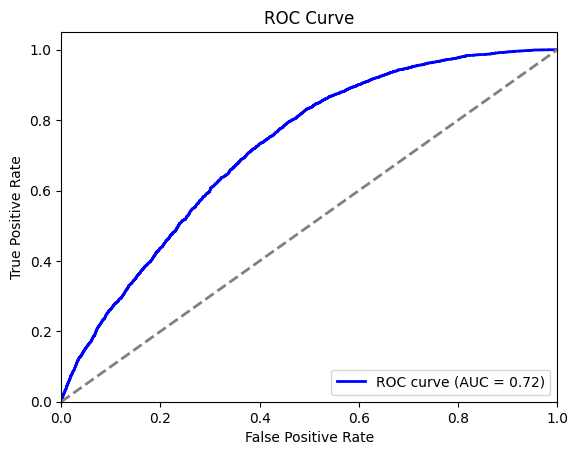

Processing OOD data: 100%|█████████████████████████████████████████████████████████████| 86/86 [00:51<00:00,  1.67it/s]

FPR at TPR=0.05: 0.0153
FPR at TPR=0.15: 0.0582
FPR at TPR=0.25: 0.1042
FPR at TPR=0.35: 0.1509
FPR at TPR=0.45: 0.2122
FPR at TPR=0.55: 0.2767
FPR at TPR=0.65: 0.3469
FPR at TPR=0.75: 0.4271
FPR at TPR=0.85: 0.5480
FPR at TPR=0.95: 0.7478


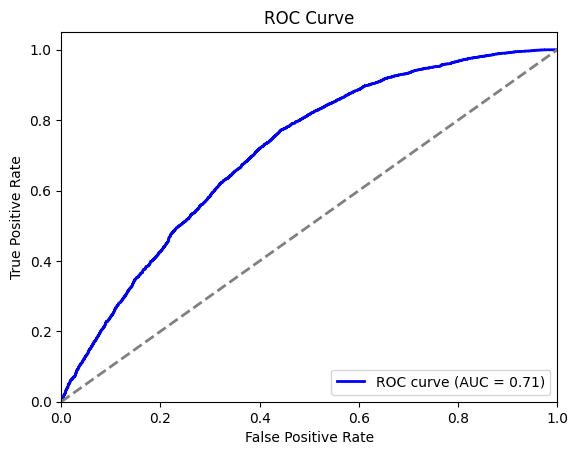

Running experiment with 55 classes (Subclass Mode)
Epoch 1/20
Train Loss: 3.3544, Train Accuracy: 16.08%
Test Loss: 2.8661, Test Accuracy: 24.24%
Epoch 2/20
Train Loss: 2.7403, Train Accuracy: 27.80%
Test Loss: 2.5399, Test Accuracy: 32.13%
Epoch 3/20
Train Loss: 2.3110, Train Accuracy: 37.27%
Test Loss: 2.2197, Test Accuracy: 40.36%
Epoch 4/20
Train Loss: 1.9934, Train Accuracy: 44.27%
Test Loss: 1.9664, Test Accuracy: 45.82%
Epoch 5/20
Train Loss: 1.7240, Train Accuracy: 50.93%
Test Loss: 1.7488, Test Accuracy: 50.85%
Epoch 6/20
Train Loss: 1.5149, Train Accuracy: 56.22%
Test Loss: 1.6488, Test Accuracy: 53.64%
Epoch 7/20
Train Loss: 1.3428, Train Accuracy: 60.55%
Test Loss: 1.5676, Test Accuracy: 55.38%
Epoch 8/20
Train Loss: 1.2011, Train Accuracy: 64.31%
Test Loss: 1.5806, Test Accuracy: 57.11%
Epoch 9/20
Train Loss: 1.0816, Train Accuracy: 67.47%
Test Loss: 1.3290, Test Accuracy: 63.13%
Epoch 10/20
Train Loss: 0.9665, Train Accuracy: 70.62%
Test Loss: 1.2482, Test Accuracy: 64.78

FPR at TPR=0.05: 0.0160
FPR at TPR=0.15: 0.0562
FPR at TPR=0.25: 0.1047
FPR at TPR=0.35: 0.1525
FPR at TPR=0.45: 0.2107
FPR at TPR=0.55: 0.2642
FPR at TPR=0.65: 0.3362
FPR at TPR=0.75: 0.4184
FPR at TPR=0.85: 0.5235
FPR at TPR=0.95: 0.7051


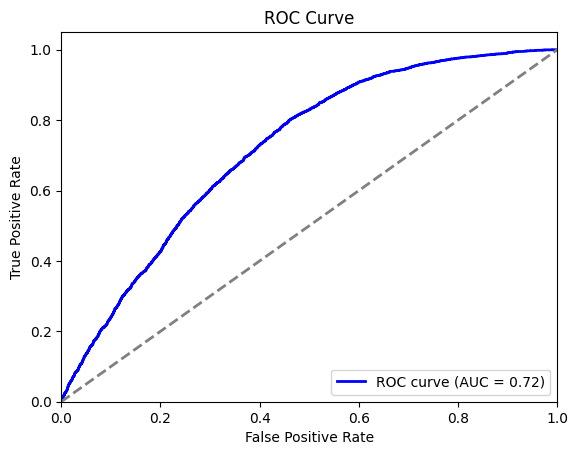

Processing OOD data: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:50<00:00,  1.39it/s]

FPR at TPR=0.05: 0.0195
FPR at TPR=0.15: 0.0649
FPR at TPR=0.25: 0.1149
FPR at TPR=0.35: 0.1685
FPR at TPR=0.45: 0.2296
FPR at TPR=0.55: 0.3080
FPR at TPR=0.65: 0.3778
FPR at TPR=0.75: 0.4633
FPR at TPR=0.85: 0.5965
FPR at TPR=0.95: 0.7747


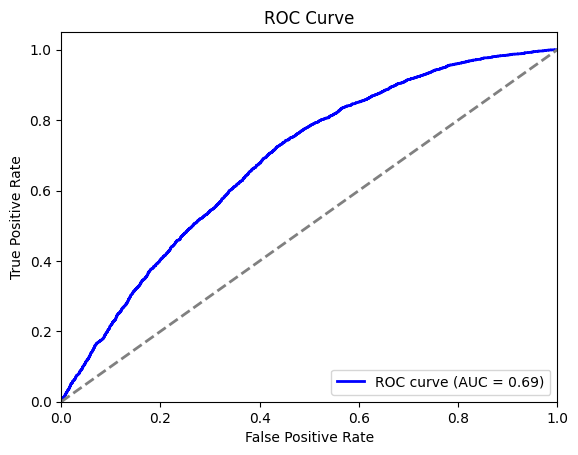

Running experiment with 65 classes (Subclass Mode)
Epoch 1/20
Train Loss: 3.4145, Train Accuracy: 15.69%
Test Loss: 3.2714, Test Accuracy: 19.92%
Epoch 2/20
Train Loss: 2.7608, Train Accuracy: 28.03%
Test Loss: 2.5688, Test Accuracy: 32.89%
Epoch 3/20
Train Loss: 2.3051, Train Accuracy: 37.36%
Test Loss: 2.5360, Test Accuracy: 34.92%
Epoch 4/20
Train Loss: 1.9458, Train Accuracy: 45.51%
Test Loss: 1.9348, Test Accuracy: 46.74%
Epoch 5/20
Train Loss: 1.6845, Train Accuracy: 51.82%
Test Loss: 1.6983, Test Accuracy: 52.63%
Epoch 6/20
Train Loss: 1.4861, Train Accuracy: 56.48%
Test Loss: 1.6219, Test Accuracy: 55.69%
Epoch 7/20
Train Loss: 1.3262, Train Accuracy: 61.24%
Test Loss: 1.4999, Test Accuracy: 58.12%
Epoch 8/20
Train Loss: 1.2031, Train Accuracy: 64.06%
Test Loss: 1.3586, Test Accuracy: 61.54%
Epoch 9/20
Train Loss: 1.0794, Train Accuracy: 67.48%
Test Loss: 1.3215, Test Accuracy: 62.54%
Epoch 10/20
Train Loss: 0.9766, Train Accuracy: 70.37%
Test Loss: 1.2291, Test Accuracy: 64.42

FPR at TPR=0.05: 0.0132
FPR at TPR=0.15: 0.0468
FPR at TPR=0.25: 0.0940
FPR at TPR=0.35: 0.1440
FPR at TPR=0.45: 0.2032
FPR at TPR=0.55: 0.2648
FPR at TPR=0.65: 0.3405
FPR at TPR=0.75: 0.4097
FPR at TPR=0.85: 0.5228
FPR at TPR=0.95: 0.7100


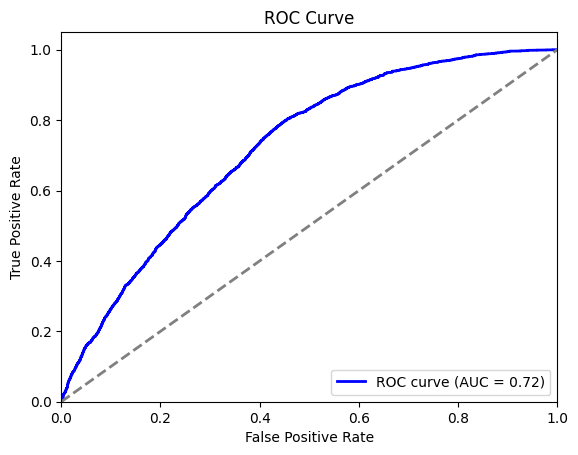

Processing OOD data: 100%|█████████████████████████████████████████████████████████████| 55/55 [00:46<00:00,  1.18it/s]

FPR at TPR=0.05: 0.0212
FPR at TPR=0.15: 0.0692
FPR at TPR=0.25: 0.1220
FPR at TPR=0.35: 0.1792
FPR at TPR=0.45: 0.2429
FPR at TPR=0.55: 0.3151
FPR at TPR=0.65: 0.3906
FPR at TPR=0.75: 0.4751
FPR at TPR=0.85: 0.6028
FPR at TPR=0.95: 0.7671


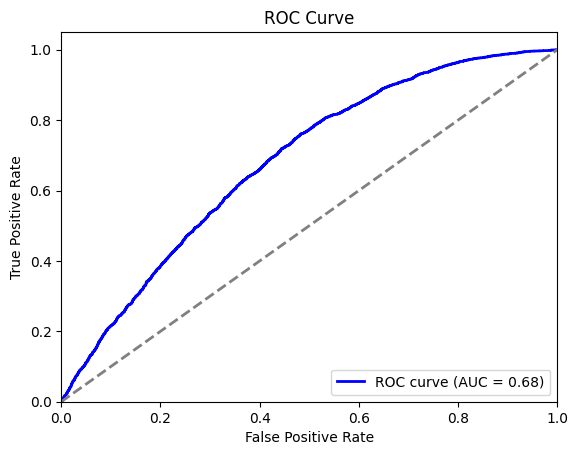

Running experiment with 75 classes (Subclass Mode)
Epoch 1/20
Train Loss: 3.4866, Train Accuracy: 14.94%
Test Loss: 3.0058, Test Accuracy: 23.65%
Epoch 2/20
Train Loss: 2.8029, Train Accuracy: 27.32%
Test Loss: 2.4639, Test Accuracy: 34.91%
Epoch 3/20
Train Loss: 2.3447, Train Accuracy: 36.76%
Test Loss: 2.2140, Test Accuracy: 40.69%
Epoch 4/20
Train Loss: 2.0161, Train Accuracy: 44.24%
Test Loss: 2.0152, Test Accuracy: 45.27%
Epoch 5/20
Train Loss: 1.7541, Train Accuracy: 50.55%
Test Loss: 1.7937, Test Accuracy: 51.40%
Epoch 6/20
Train Loss: 1.5569, Train Accuracy: 55.34%
Test Loss: 1.6068, Test Accuracy: 54.15%
Epoch 7/20
Train Loss: 1.4141, Train Accuracy: 58.74%
Test Loss: 1.5251, Test Accuracy: 56.41%
Epoch 8/20
Train Loss: 1.2719, Train Accuracy: 62.62%
Test Loss: 1.4954, Test Accuracy: 58.28%
Epoch 9/20
Train Loss: 1.1501, Train Accuracy: 65.35%
Test Loss: 1.3860, Test Accuracy: 61.23%
Epoch 10/20
Train Loss: 1.0502, Train Accuracy: 68.76%
Test Loss: 1.3795, Test Accuracy: 61.48

FPR at TPR=0.05: 0.0115
FPR at TPR=0.15: 0.0489
FPR at TPR=0.25: 0.0909
FPR at TPR=0.35: 0.1372
FPR at TPR=0.45: 0.1900
FPR at TPR=0.55: 0.2505
FPR at TPR=0.65: 0.3177
FPR at TPR=0.75: 0.4089
FPR at TPR=0.85: 0.5045
FPR at TPR=0.95: 0.6669


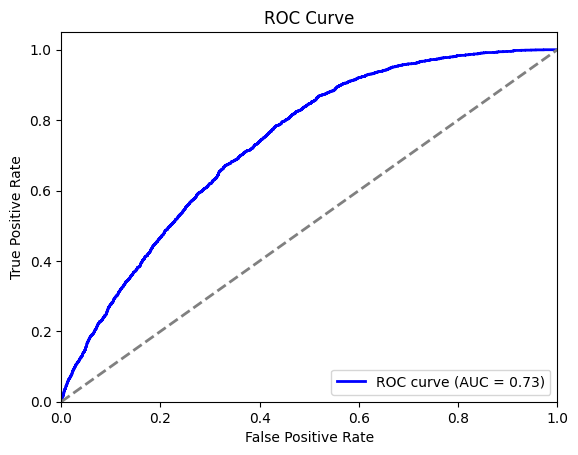

Processing OOD data: 100%|█████████████████████████████████████████████████████████████| 40/40 [00:39<00:00,  1.02it/s]

FPR at TPR=0.05: 0.0211
FPR at TPR=0.15: 0.0601
FPR at TPR=0.25: 0.1087
FPR at TPR=0.35: 0.1617
FPR at TPR=0.45: 0.2219
FPR at TPR=0.55: 0.2941
FPR at TPR=0.65: 0.3775
FPR at TPR=0.75: 0.4709
FPR at TPR=0.85: 0.5733
FPR at TPR=0.95: 0.7560


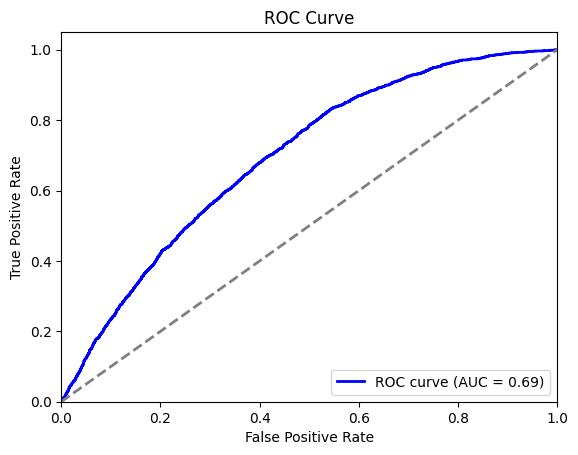

Running experiment with 85 classes (Subclass Mode)
Epoch 1/20
Train Loss: 3.6080, Train Accuracy: 13.67%
Test Loss: 3.2336, Test Accuracy: 20.73%
Epoch 2/20
Train Loss: 2.9221, Train Accuracy: 25.88%
Test Loss: 2.7396, Test Accuracy: 30.60%
Epoch 3/20
Train Loss: 2.4353, Train Accuracy: 35.50%
Test Loss: 2.2549, Test Accuracy: 40.69%
Epoch 4/20
Train Loss: 2.0878, Train Accuracy: 43.07%
Test Loss: 2.0849, Test Accuracy: 44.27%
Epoch 5/20
Train Loss: 1.8216, Train Accuracy: 49.33%
Test Loss: 1.8408, Test Accuracy: 49.31%
Epoch 6/20
Train Loss: 1.6303, Train Accuracy: 54.03%
Test Loss: 1.7631, Test Accuracy: 52.42%
Epoch 7/20
Train Loss: 1.4659, Train Accuracy: 57.99%
Test Loss: 1.6381, Test Accuracy: 55.22%
Epoch 8/20
Train Loss: 1.3218, Train Accuracy: 61.69%
Test Loss: 1.5425, Test Accuracy: 57.47%
Epoch 9/20
Train Loss: 1.1994, Train Accuracy: 64.82%
Test Loss: 1.4180, Test Accuracy: 60.34%
Epoch 10/20
Train Loss: 1.0902, Train Accuracy: 67.90%
Test Loss: 1.3845, Test Accuracy: 61.15

FPR at TPR=0.05: 0.0178
FPR at TPR=0.15: 0.0531
FPR at TPR=0.25: 0.0921
FPR at TPR=0.35: 0.1341
FPR at TPR=0.45: 0.1893
FPR at TPR=0.55: 0.2491
FPR at TPR=0.65: 0.3189
FPR at TPR=0.75: 0.3962
FPR at TPR=0.85: 0.4972
FPR at TPR=0.95: 0.6608


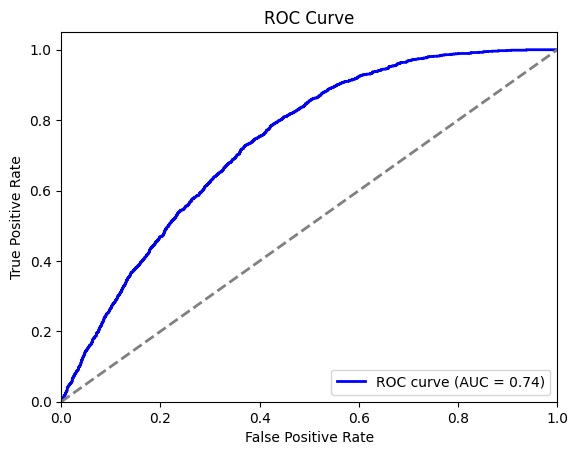

Processing OOD data: 100%|█████████████████████████████████████████████████████████████| 24/24 [00:29<00:00,  1.23s/it]

FPR at TPR=0.05: 0.0254
FPR at TPR=0.15: 0.0780
FPR at TPR=0.25: 0.1375
FPR at TPR=0.35: 0.1984
FPR at TPR=0.45: 0.2532
FPR at TPR=0.55: 0.3260
FPR at TPR=0.65: 0.4018
FPR at TPR=0.75: 0.5015
FPR at TPR=0.85: 0.6145
FPR at TPR=0.95: 0.7635


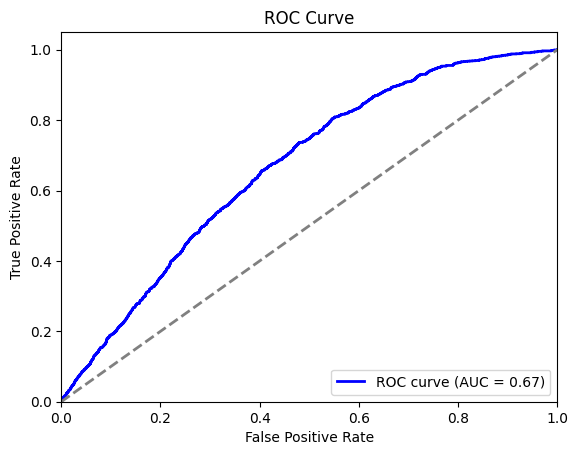

Running experiment with 95 classes (Subclass Mode)
Epoch 1/20
Train Loss: 3.6762, Train Accuracy: 13.38%
Test Loss: 3.2633, Test Accuracy: 20.76%
Epoch 2/20
Train Loss: 2.9064, Train Accuracy: 26.44%
Test Loss: 2.6537, Test Accuracy: 31.60%
Epoch 3/20
Train Loss: 2.3901, Train Accuracy: 37.13%
Test Loss: 2.4424, Test Accuracy: 36.43%
Epoch 4/20
Train Loss: 2.0428, Train Accuracy: 44.63%
Test Loss: 2.0770, Test Accuracy: 44.52%
Epoch 5/20
Train Loss: 1.7837, Train Accuracy: 50.97%
Test Loss: 1.9507, Test Accuracy: 48.36%
Epoch 6/20
Train Loss: 1.6007, Train Accuracy: 54.88%
Test Loss: 1.7330, Test Accuracy: 52.57%
Epoch 7/20
Train Loss: 1.4427, Train Accuracy: 58.95%
Test Loss: 1.5893, Test Accuracy: 56.57%
Epoch 8/20
Train Loss: 1.3096, Train Accuracy: 62.48%
Test Loss: 1.4821, Test Accuracy: 58.93%
Epoch 9/20
Train Loss: 1.1930, Train Accuracy: 65.49%
Test Loss: 1.4692, Test Accuracy: 60.07%
Epoch 10/20
Train Loss: 1.0912, Train Accuracy: 68.03%
Test Loss: 1.3304, Test Accuracy: 62.84

FPR at TPR=0.05: 0.0167
FPR at TPR=0.15: 0.0553
FPR at TPR=0.25: 0.1063
FPR at TPR=0.35: 0.1546
FPR at TPR=0.45: 0.2003
FPR at TPR=0.55: 0.2624
FPR at TPR=0.65: 0.3445
FPR at TPR=0.75: 0.4299
FPR at TPR=0.85: 0.5260
FPR at TPR=0.95: 0.6772


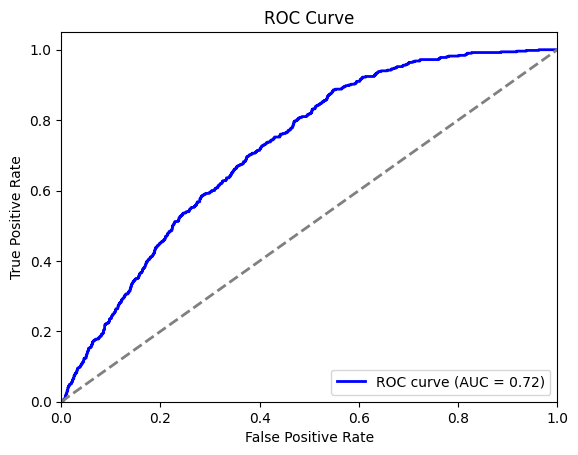

Processing OOD data: 100%|███████████████████████████████████████████████████████████████| 8/8 [00:15<00:00,  1.95s/it]

FPR at TPR=0.05: 0.0146
FPR at TPR=0.15: 0.0816
FPR at TPR=0.25: 0.1456
FPR at TPR=0.35: 0.2018
FPR at TPR=0.45: 0.2700
FPR at TPR=0.55: 0.3419
FPR at TPR=0.65: 0.4232
FPR at TPR=0.75: 0.5469
FPR at TPR=0.85: 0.6751
FPR at TPR=0.95: 0.8461


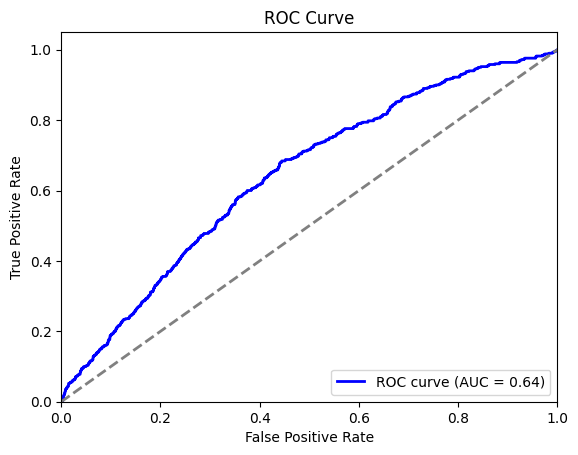

Running experiment with 5 classes (Superclass Mode)
Epoch 1/20
Train Loss: 1.6308, Train Accuracy: 36.72%
Test Loss: 2.2262, Test Accuracy: 32.80%
Epoch 2/20
Train Loss: 1.4597, Train Accuracy: 39.04%
Test Loss: 1.4419, Test Accuracy: 46.60%
Epoch 3/20
Train Loss: 1.2549, Train Accuracy: 43.00%
Test Loss: 1.3621, Test Accuracy: 45.20%
Epoch 4/20
Train Loss: 1.2462, Train Accuracy: 45.84%
Test Loss: 1.2695, Test Accuracy: 46.20%
Epoch 5/20
Train Loss: 1.2583, Train Accuracy: 44.92%
Test Loss: 1.2761, Test Accuracy: 49.20%
Epoch 6/20
Train Loss: 1.2376, Train Accuracy: 44.84%
Test Loss: 1.1845, Test Accuracy: 48.60%
Epoch 7/20
Train Loss: 1.1659, Train Accuracy: 49.80%
Test Loss: 1.1847, Test Accuracy: 49.60%
Epoch 8/20
Train Loss: 1.1408, Train Accuracy: 50.56%
Test Loss: 1.2022, Test Accuracy: 47.40%
Epoch 9/20
Train Loss: 1.1198, Train Accuracy: 52.56%
Test Loss: 1.1496, Test Accuracy: 50.00%
Epoch 10/20
Train Loss: 1.1125, Train Accuracy: 51.00%
Test Loss: 1.1808, Test Accuracy: 51.6

FPR at TPR=0.05: 0.0500
FPR at TPR=0.15: 0.1100
FPR at TPR=0.25: 0.1920
FPR at TPR=0.35: 0.2840
FPR at TPR=0.45: 0.3740
FPR at TPR=0.55: 0.4820
FPR at TPR=0.65: 0.5680
FPR at TPR=0.75: 0.6840
FPR at TPR=0.85: 0.8120
FPR at TPR=0.95: 0.9240


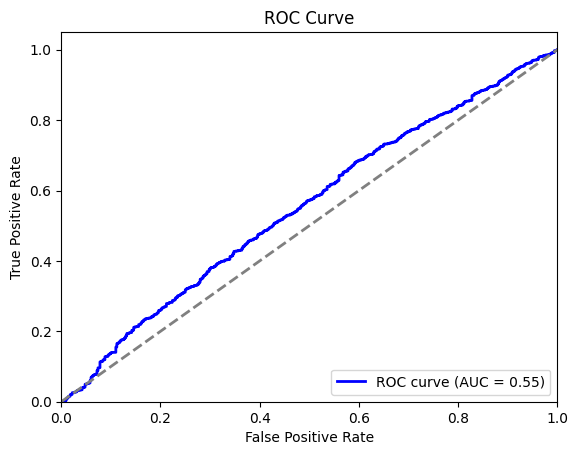

Processing OOD data: 100%|███████████████████████████████████████████████████████████| 149/149 [00:17<00:00,  8.71it/s]

FPR at TPR=0.05: 0.0040
FPR at TPR=0.15: 0.0280
FPR at TPR=0.25: 0.0900
FPR at TPR=0.35: 0.1460
FPR at TPR=0.45: 0.2280
FPR at TPR=0.55: 0.3180
FPR at TPR=0.65: 0.4360
FPR at TPR=0.75: 0.5260
FPR at TPR=0.85: 0.6420
FPR at TPR=0.95: 0.7920


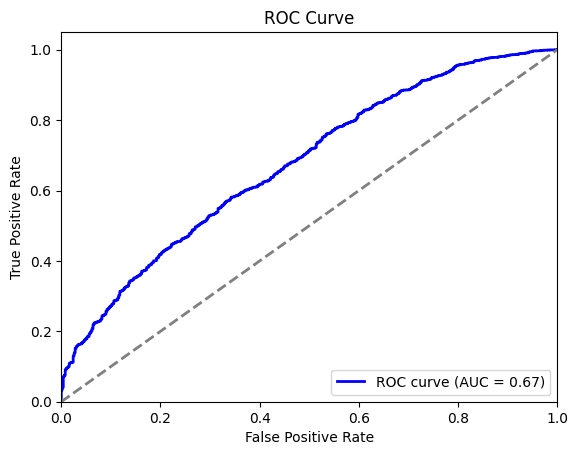

Running experiment with 15 classes (Superclass Mode)
Epoch 1/20
Train Loss: 2.1726, Train Accuracy: 28.01%
Test Loss: 2.0109, Test Accuracy: 29.93%
Epoch 2/20
Train Loss: 1.8187, Train Accuracy: 36.75%
Test Loss: 1.7091, Test Accuracy: 41.60%
Epoch 3/20
Train Loss: 1.6985, Train Accuracy: 40.91%
Test Loss: 1.5975, Test Accuracy: 41.87%
Epoch 4/20
Train Loss: 1.6073, Train Accuracy: 43.33%
Test Loss: 1.6440, Test Accuracy: 44.40%
Epoch 5/20
Train Loss: 1.5391, Train Accuracy: 45.61%
Test Loss: 1.5871, Test Accuracy: 49.53%
Epoch 6/20
Train Loss: 1.4645, Train Accuracy: 47.84%
Test Loss: 1.4303, Test Accuracy: 50.20%
Epoch 7/20
Train Loss: 1.4203, Train Accuracy: 49.32%
Test Loss: 1.5363, Test Accuracy: 45.27%
Epoch 8/20
Train Loss: 1.3418, Train Accuracy: 51.89%
Test Loss: 1.4538, Test Accuracy: 50.53%
Epoch 9/20
Train Loss: 1.2684, Train Accuracy: 54.99%
Test Loss: 1.4821, Test Accuracy: 49.40%
Epoch 10/20
Train Loss: 1.2048, Train Accuracy: 57.31%
Test Loss: 1.3714, Test Accuracy: 53.

FPR at TPR=0.05: 0.0173
FPR at TPR=0.15: 0.0600
FPR at TPR=0.25: 0.1040
FPR at TPR=0.35: 0.1707
FPR at TPR=0.45: 0.2307
FPR at TPR=0.55: 0.3073
FPR at TPR=0.65: 0.3827
FPR at TPR=0.75: 0.4827
FPR at TPR=0.85: 0.5920
FPR at TPR=0.95: 0.7340


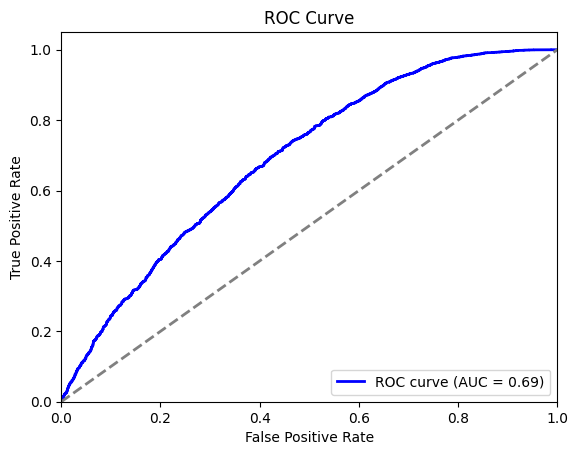

Processing OOD data: 100%|███████████████████████████████████████████████████████████| 133/133 [00:32<00:00,  4.13it/s]

FPR at TPR=0.05: 0.0167
FPR at TPR=0.15: 0.0387
FPR at TPR=0.25: 0.0720
FPR at TPR=0.35: 0.1047
FPR at TPR=0.45: 0.1473
FPR at TPR=0.55: 0.2000
FPR at TPR=0.65: 0.2793
FPR at TPR=0.75: 0.3880
FPR at TPR=0.85: 0.5100
FPR at TPR=0.95: 0.7367


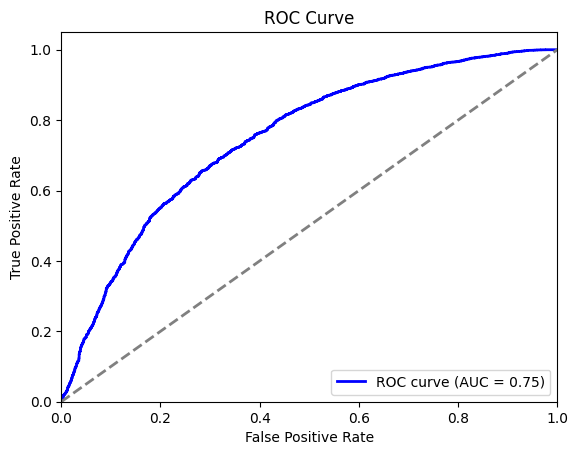

Running experiment with 25 classes (Superclass Mode)
Epoch 1/20
Train Loss: 2.5841, Train Accuracy: 22.64%
Test Loss: 2.2673, Test Accuracy: 28.60%
Epoch 2/20
Train Loss: 2.2015, Train Accuracy: 31.41%
Test Loss: 2.1068, Test Accuracy: 33.16%
Epoch 3/20
Train Loss: 2.0135, Train Accuracy: 36.86%
Test Loss: 1.9912, Test Accuracy: 35.68%
Epoch 4/20
Train Loss: 1.8524, Train Accuracy: 40.93%
Test Loss: 1.8625, Test Accuracy: 41.52%
Epoch 5/20
Train Loss: 1.6887, Train Accuracy: 45.86%
Test Loss: 1.7031, Test Accuracy: 46.88%
Epoch 6/20
Train Loss: 1.5435, Train Accuracy: 50.30%
Test Loss: 1.5953, Test Accuracy: 49.76%
Epoch 7/20
Train Loss: 1.4070, Train Accuracy: 54.48%
Test Loss: 1.5779, Test Accuracy: 51.80%
Epoch 8/20
Train Loss: 1.2769, Train Accuracy: 58.04%
Test Loss: 1.3004, Test Accuracy: 57.84%
Epoch 9/20
Train Loss: 1.1779, Train Accuracy: 60.90%
Test Loss: 1.3698, Test Accuracy: 54.64%
Epoch 10/20
Train Loss: 1.0719, Train Accuracy: 64.38%
Test Loss: 1.3601, Test Accuracy: 58.

FPR at TPR=0.05: 0.0084
FPR at TPR=0.15: 0.0388
FPR at TPR=0.25: 0.0688
FPR at TPR=0.35: 0.1164
FPR at TPR=0.45: 0.1676
FPR at TPR=0.55: 0.2304
FPR at TPR=0.65: 0.2972
FPR at TPR=0.75: 0.3864
FPR at TPR=0.85: 0.4852
FPR at TPR=0.95: 0.6444


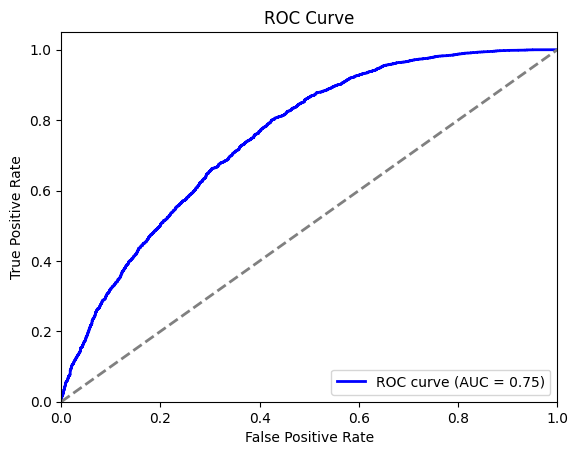

Processing OOD data: 100%|███████████████████████████████████████████████████████████| 118/118 [00:40<00:00,  2.90it/s]

FPR at TPR=0.05: 0.0156
FPR at TPR=0.15: 0.0448
FPR at TPR=0.25: 0.0860
FPR at TPR=0.35: 0.1228
FPR at TPR=0.45: 0.1616
FPR at TPR=0.55: 0.2236
FPR at TPR=0.65: 0.2856
FPR at TPR=0.75: 0.3660
FPR at TPR=0.85: 0.4700
FPR at TPR=0.95: 0.6496


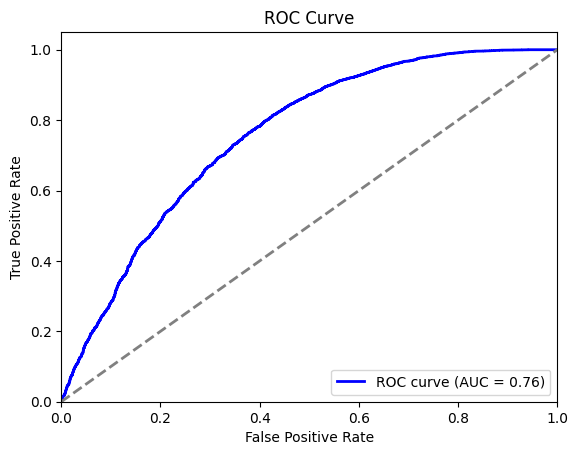

Running experiment with 35 classes (Superclass Mode)
Epoch 1/20
Train Loss: 2.9543, Train Accuracy: 18.10%
Test Loss: 2.6327, Test Accuracy: 23.51%
Epoch 2/20
Train Loss: 2.5032, Train Accuracy: 27.28%
Test Loss: 2.4419, Test Accuracy: 29.77%
Epoch 3/20
Train Loss: 2.1979, Train Accuracy: 34.47%
Test Loss: 1.9979, Test Accuracy: 40.77%
Epoch 4/20
Train Loss: 1.9109, Train Accuracy: 42.41%
Test Loss: 1.8179, Test Accuracy: 46.26%
Epoch 5/20
Train Loss: 1.6801, Train Accuracy: 48.60%
Test Loss: 1.6933, Test Accuracy: 49.51%
Epoch 6/20
Train Loss: 1.5203, Train Accuracy: 52.74%
Test Loss: 1.5634, Test Accuracy: 52.80%
Epoch 7/20
Train Loss: 1.3701, Train Accuracy: 57.16%
Test Loss: 1.4235, Test Accuracy: 57.09%
Epoch 8/20
Train Loss: 1.2415, Train Accuracy: 60.67%
Test Loss: 1.4384, Test Accuracy: 57.29%
Epoch 9/20
Train Loss: 1.1385, Train Accuracy: 63.97%
Test Loss: 1.2807, Test Accuracy: 62.11%
Epoch 10/20
Train Loss: 1.0326, Train Accuracy: 66.84%
Test Loss: 1.2455, Test Accuracy: 62.

FPR at TPR=0.05: 0.0080
FPR at TPR=0.15: 0.0297
FPR at TPR=0.25: 0.0674
FPR at TPR=0.35: 0.1123
FPR at TPR=0.45: 0.1549
FPR at TPR=0.55: 0.2114
FPR at TPR=0.65: 0.2740
FPR at TPR=0.75: 0.3477
FPR at TPR=0.85: 0.4337
FPR at TPR=0.95: 0.5669


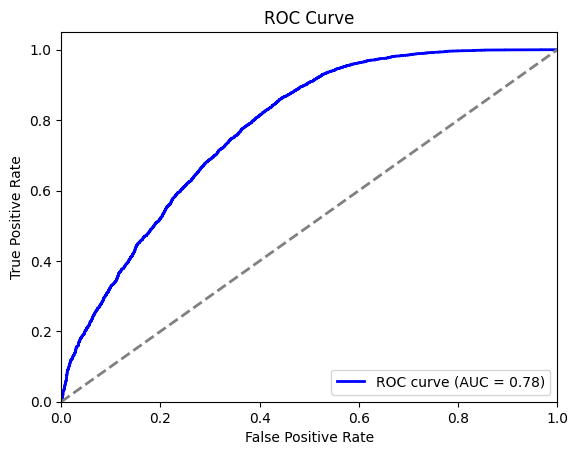

Processing OOD data: 100%|███████████████████████████████████████████████████████████| 102/102 [00:48<00:00,  2.12it/s]

FPR at TPR=0.05: 0.0217
FPR at TPR=0.15: 0.0531
FPR at TPR=0.25: 0.0863
FPR at TPR=0.35: 0.1246
FPR at TPR=0.45: 0.1703
FPR at TPR=0.55: 0.2211
FPR at TPR=0.65: 0.2686
FPR at TPR=0.75: 0.3403
FPR at TPR=0.85: 0.4566
FPR at TPR=0.95: 0.6343


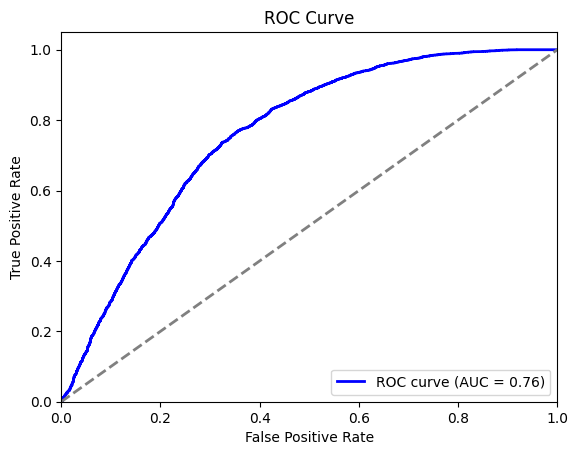

Running experiment with 45 classes (Superclass Mode)
Epoch 1/20
Train Loss: 3.1284, Train Accuracy: 16.50%
Test Loss: 2.9233, Test Accuracy: 21.11%
Epoch 2/20
Train Loss: 2.5938, Train Accuracy: 27.66%
Test Loss: 2.5904, Test Accuracy: 30.16%
Epoch 3/20
Train Loss: 2.2373, Train Accuracy: 35.77%
Test Loss: 2.1618, Test Accuracy: 38.02%
Epoch 4/20
Train Loss: 1.9372, Train Accuracy: 42.84%
Test Loss: 2.1564, Test Accuracy: 41.16%
Epoch 5/20
Train Loss: 1.6964, Train Accuracy: 49.93%
Test Loss: 1.7164, Test Accuracy: 50.53%
Epoch 6/20
Train Loss: 1.5072, Train Accuracy: 54.72%
Test Loss: 1.6187, Test Accuracy: 53.00%
Epoch 7/20
Train Loss: 1.3751, Train Accuracy: 58.40%
Test Loss: 1.4759, Test Accuracy: 56.51%
Epoch 8/20
Train Loss: 1.2361, Train Accuracy: 61.78%
Test Loss: 1.3635, Test Accuracy: 60.22%
Epoch 9/20
Train Loss: 1.1198, Train Accuracy: 65.31%
Test Loss: 1.3617, Test Accuracy: 60.27%
Epoch 10/20
Train Loss: 1.0160, Train Accuracy: 68.17%
Test Loss: 1.2460, Test Accuracy: 63.

FPR at TPR=0.05: 0.0109
FPR at TPR=0.15: 0.0331
FPR at TPR=0.25: 0.0633
FPR at TPR=0.35: 0.0982
FPR at TPR=0.45: 0.1429
FPR at TPR=0.55: 0.1967
FPR at TPR=0.65: 0.2642
FPR at TPR=0.75: 0.3389
FPR at TPR=0.85: 0.4356
FPR at TPR=0.95: 0.5898


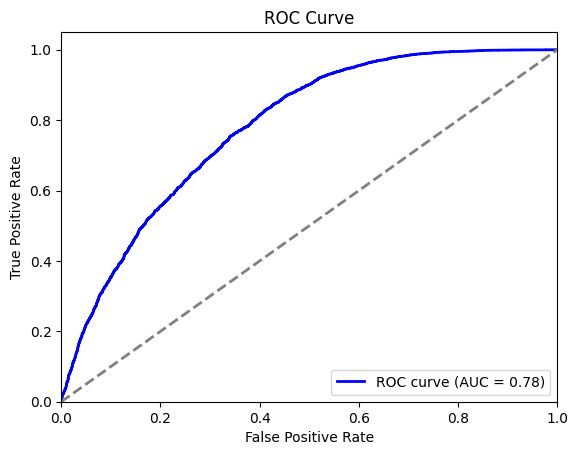

Processing OOD data: 100%|█████████████████████████████████████████████████████████████| 86/86 [00:51<00:00,  1.66it/s]

FPR at TPR=0.05: 0.0131
FPR at TPR=0.15: 0.0427
FPR at TPR=0.25: 0.0736
FPR at TPR=0.35: 0.1149
FPR at TPR=0.45: 0.1547
FPR at TPR=0.55: 0.1973
FPR at TPR=0.65: 0.2504
FPR at TPR=0.75: 0.3233
FPR at TPR=0.85: 0.4351
FPR at TPR=0.95: 0.6127


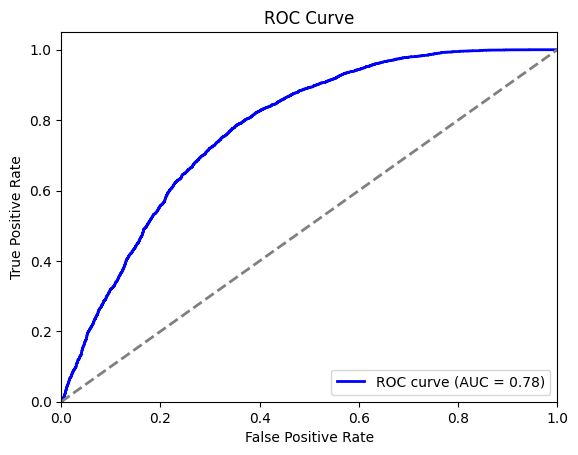

Running experiment with 55 classes (Superclass Mode)
Epoch 1/20
Train Loss: 3.1495, Train Accuracy: 17.95%
Test Loss: 2.7045, Test Accuracy: 26.82%
Epoch 2/20
Train Loss: 2.5139, Train Accuracy: 30.72%
Test Loss: 2.3099, Test Accuracy: 36.02%
Epoch 3/20
Train Loss: 2.1229, Train Accuracy: 39.72%
Test Loss: 2.1039, Test Accuracy: 42.29%
Epoch 4/20
Train Loss: 1.8336, Train Accuracy: 46.89%
Test Loss: 1.8502, Test Accuracy: 48.64%
Epoch 5/20
Train Loss: 1.5951, Train Accuracy: 53.11%
Test Loss: 1.6650, Test Accuracy: 52.49%
Epoch 6/20
Train Loss: 1.4298, Train Accuracy: 57.43%
Test Loss: 1.5717, Test Accuracy: 55.56%
Epoch 7/20
Train Loss: 1.2800, Train Accuracy: 61.30%
Test Loss: 1.4134, Test Accuracy: 59.56%
Epoch 8/20
Train Loss: 1.1542, Train Accuracy: 64.93%
Test Loss: 1.3331, Test Accuracy: 61.76%
Epoch 9/20
Train Loss: 1.0442, Train Accuracy: 67.99%
Test Loss: 1.3995, Test Accuracy: 61.04%
Epoch 10/20
Train Loss: 0.9452, Train Accuracy: 71.07%
Test Loss: 1.2367, Test Accuracy: 63.

FPR at TPR=0.05: 0.0082
FPR at TPR=0.15: 0.0355
FPR at TPR=0.25: 0.0687
FPR at TPR=0.35: 0.1024
FPR at TPR=0.45: 0.1493
FPR at TPR=0.55: 0.2038
FPR at TPR=0.65: 0.2627
FPR at TPR=0.75: 0.3347
FPR at TPR=0.85: 0.4233
FPR at TPR=0.95: 0.6095


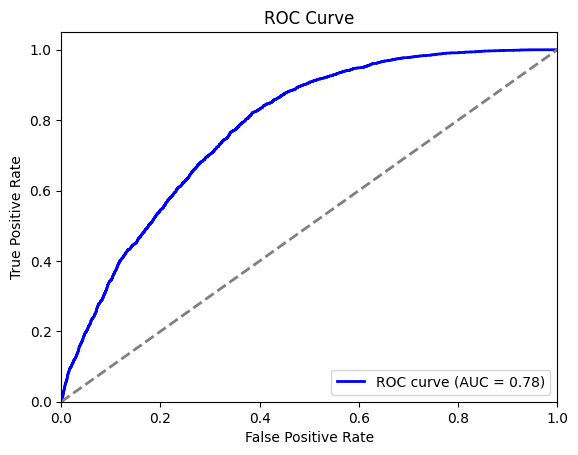

Processing OOD data: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:50<00:00,  1.40it/s]

FPR at TPR=0.05: 0.0211
FPR at TPR=0.15: 0.0553
FPR at TPR=0.25: 0.0853
FPR at TPR=0.35: 0.1185
FPR at TPR=0.45: 0.1575
FPR at TPR=0.55: 0.2027
FPR at TPR=0.65: 0.2558
FPR at TPR=0.75: 0.3198
FPR at TPR=0.85: 0.4076
FPR at TPR=0.95: 0.5664


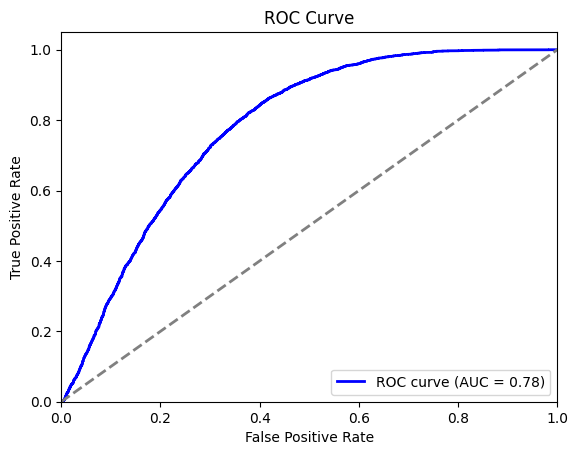

Running experiment with 65 classes (Superclass Mode)
Epoch 1/20
Train Loss: 3.3187, Train Accuracy: 16.45%
Test Loss: 2.9452, Test Accuracy: 24.62%
Epoch 2/20
Train Loss: 2.6606, Train Accuracy: 28.91%
Test Loss: 2.4708, Test Accuracy: 33.89%
Epoch 3/20
Train Loss: 2.2343, Train Accuracy: 38.37%
Test Loss: 2.1572, Test Accuracy: 40.78%
Epoch 4/20
Train Loss: 1.8965, Train Accuracy: 46.45%
Test Loss: 1.9411, Test Accuracy: 46.31%
Epoch 5/20
Train Loss: 1.6627, Train Accuracy: 51.78%
Test Loss: 1.7201, Test Accuracy: 52.32%
Epoch 6/20
Train Loss: 1.4805, Train Accuracy: 56.80%
Test Loss: 1.6019, Test Accuracy: 55.08%
Epoch 7/20
Train Loss: 1.3252, Train Accuracy: 60.98%
Test Loss: 1.4593, Test Accuracy: 58.23%
Epoch 8/20
Train Loss: 1.1930, Train Accuracy: 64.34%
Test Loss: 1.3658, Test Accuracy: 60.86%
Epoch 9/20
Train Loss: 1.0842, Train Accuracy: 67.57%
Test Loss: 1.2640, Test Accuracy: 64.06%
Epoch 10/20
Train Loss: 0.9804, Train Accuracy: 70.52%
Test Loss: 1.1998, Test Accuracy: 65.

FPR at TPR=0.05: 0.0094
FPR at TPR=0.15: 0.0322
FPR at TPR=0.25: 0.0589
FPR at TPR=0.35: 0.0938
FPR at TPR=0.45: 0.1403
FPR at TPR=0.55: 0.2006
FPR at TPR=0.65: 0.2605
FPR at TPR=0.75: 0.3380
FPR at TPR=0.85: 0.4223
FPR at TPR=0.95: 0.5865


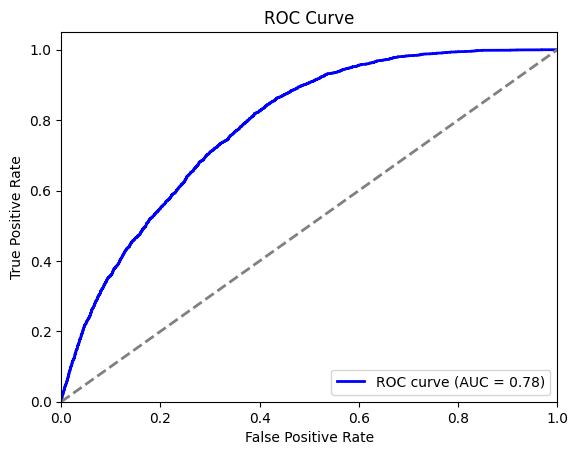

Processing OOD data: 100%|█████████████████████████████████████████████████████████████| 55/55 [00:47<00:00,  1.15it/s]

FPR at TPR=0.05: 0.0148
FPR at TPR=0.15: 0.0397
FPR at TPR=0.25: 0.0672
FPR at TPR=0.35: 0.0991
FPR at TPR=0.45: 0.1332
FPR at TPR=0.55: 0.1729
FPR at TPR=0.65: 0.2240
FPR at TPR=0.75: 0.2900
FPR at TPR=0.85: 0.3702
FPR at TPR=0.95: 0.5326


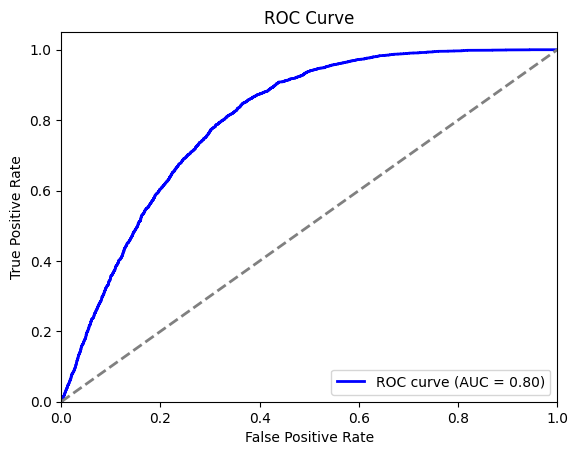

Running experiment with 75 classes (Superclass Mode)
Epoch 1/20
Train Loss: 3.5103, Train Accuracy: 14.13%
Test Loss: 3.1627, Test Accuracy: 20.83%
Epoch 2/20
Train Loss: 2.8642, Train Accuracy: 25.67%
Test Loss: 2.7447, Test Accuracy: 29.40%
Epoch 3/20
Train Loss: 2.4190, Train Accuracy: 35.28%
Test Loss: 2.2437, Test Accuracy: 39.00%
Epoch 4/20
Train Loss: 2.0737, Train Accuracy: 42.86%
Test Loss: 2.0756, Test Accuracy: 43.51%
Epoch 5/20
Train Loss: 1.8137, Train Accuracy: 48.72%
Test Loss: 1.8236, Test Accuracy: 48.73%
Epoch 6/20
Train Loss: 1.6190, Train Accuracy: 53.65%
Test Loss: 1.6906, Test Accuracy: 52.68%
Epoch 7/20
Train Loss: 1.4513, Train Accuracy: 57.83%
Test Loss: 1.5305, Test Accuracy: 55.91%
Epoch 8/20
Train Loss: 1.3096, Train Accuracy: 61.68%
Test Loss: 1.4611, Test Accuracy: 58.92%
Epoch 9/20
Train Loss: 1.1966, Train Accuracy: 64.63%
Test Loss: 1.3413, Test Accuracy: 61.31%
Epoch 10/20
Train Loss: 1.0837, Train Accuracy: 67.87%
Test Loss: 1.3168, Test Accuracy: 62.

FPR at TPR=0.05: 0.0129
FPR at TPR=0.15: 0.0439
FPR at TPR=0.25: 0.0764
FPR at TPR=0.35: 0.1164
FPR at TPR=0.45: 0.1712
FPR at TPR=0.55: 0.2321
FPR at TPR=0.65: 0.2973
FPR at TPR=0.75: 0.3844
FPR at TPR=0.85: 0.4875
FPR at TPR=0.95: 0.6617


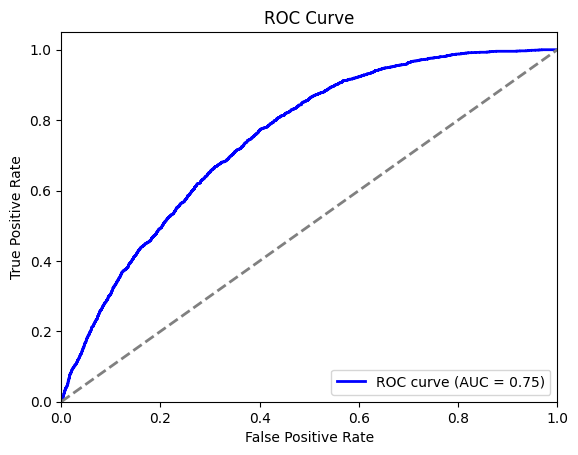

Processing OOD data: 100%|█████████████████████████████████████████████████████████████| 40/40 [00:39<00:00,  1.01it/s]

FPR at TPR=0.05: 0.0157
FPR at TPR=0.15: 0.0464
FPR at TPR=0.25: 0.0808
FPR at TPR=0.35: 0.1197
FPR at TPR=0.45: 0.1651
FPR at TPR=0.55: 0.2175
FPR at TPR=0.65: 0.2691
FPR at TPR=0.75: 0.3388
FPR at TPR=0.85: 0.4227
FPR at TPR=0.95: 0.5819


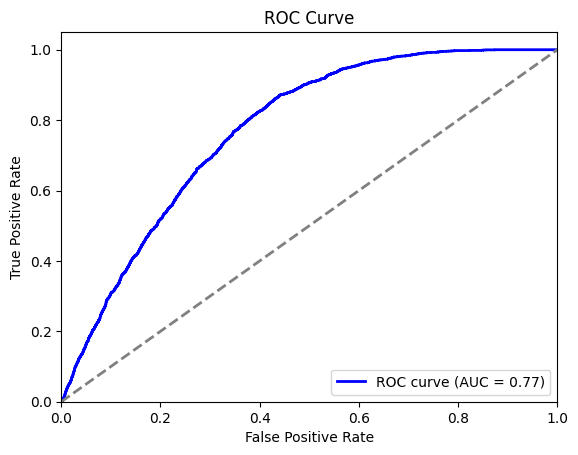

Running experiment with 85 classes (Superclass Mode)
Epoch 1/20
Train Loss: 3.6672, Train Accuracy: 12.76%
Test Loss: 3.2355, Test Accuracy: 19.96%
Epoch 2/20
Train Loss: 2.9999, Train Accuracy: 23.92%
Test Loss: 2.8254, Test Accuracy: 28.19%
Epoch 3/20
Train Loss: 2.5489, Train Accuracy: 33.08%
Test Loss: 2.6941, Test Accuracy: 32.55%
Epoch 4/20
Train Loss: 2.2241, Train Accuracy: 39.86%
Test Loss: 2.2240, Test Accuracy: 40.91%
Epoch 5/20
Train Loss: 1.9534, Train Accuracy: 46.49%
Test Loss: 2.0013, Test Accuracy: 45.51%
Epoch 6/20
Train Loss: 1.7464, Train Accuracy: 50.91%
Test Loss: 1.8493, Test Accuracy: 49.71%
Epoch 7/20
Train Loss: 1.5813, Train Accuracy: 55.38%
Test Loss: 1.7425, Test Accuracy: 52.48%
Epoch 8/20
Train Loss: 1.4331, Train Accuracy: 59.08%
Test Loss: 1.6098, Test Accuracy: 55.67%
Epoch 9/20
Train Loss: 1.3075, Train Accuracy: 62.66%
Test Loss: 1.5190, Test Accuracy: 57.42%
Epoch 10/20
Train Loss: 1.1932, Train Accuracy: 65.29%
Test Loss: 1.4320, Test Accuracy: 60.

FPR at TPR=0.05: 0.0176
FPR at TPR=0.15: 0.0544
FPR at TPR=0.25: 0.0984
FPR at TPR=0.35: 0.1601
FPR at TPR=0.45: 0.2244
FPR at TPR=0.55: 0.2956
FPR at TPR=0.65: 0.3659
FPR at TPR=0.75: 0.4562
FPR at TPR=0.85: 0.5713
FPR at TPR=0.95: 0.7389


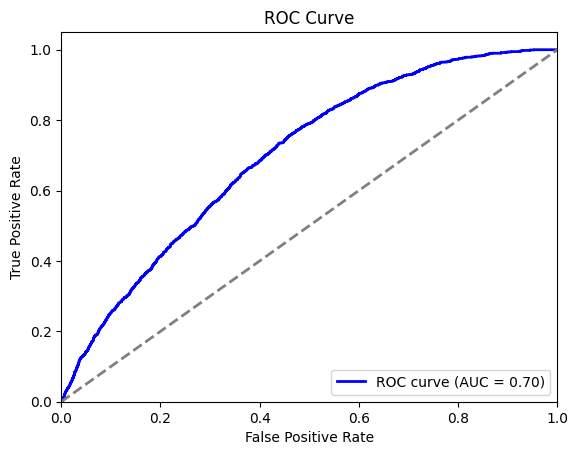

Processing OOD data: 100%|█████████████████████████████████████████████████████████████| 24/24 [00:28<00:00,  1.20s/it]

FPR at TPR=0.05: 0.0193
FPR at TPR=0.15: 0.0586
FPR at TPR=0.25: 0.0984
FPR at TPR=0.35: 0.1498
FPR at TPR=0.45: 0.1932
FPR at TPR=0.55: 0.2491
FPR at TPR=0.65: 0.3235
FPR at TPR=0.75: 0.4089
FPR at TPR=0.85: 0.5151
FPR at TPR=0.95: 0.6865


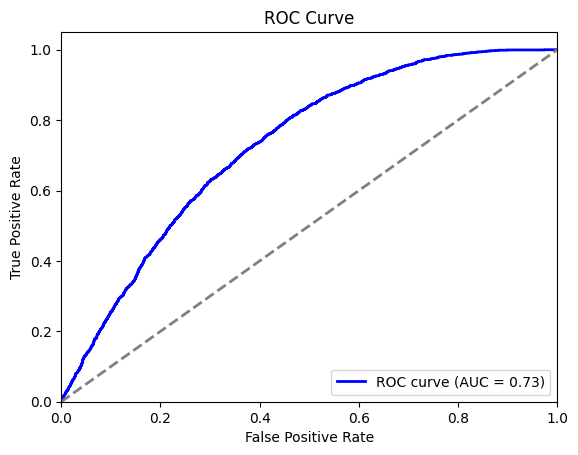

Running experiment with 95 classes (Superclass Mode)
Epoch 1/20
Train Loss: 3.7281, Train Accuracy: 12.15%
Test Loss: 3.3630, Test Accuracy: 18.62%
Epoch 2/20
Train Loss: 3.0158, Train Accuracy: 24.43%
Test Loss: 2.8690, Test Accuracy: 28.28%
Epoch 3/20
Train Loss: 2.5130, Train Accuracy: 34.18%
Test Loss: 2.4029, Test Accuracy: 37.34%
Epoch 4/20
Train Loss: 2.1528, Train Accuracy: 42.25%
Test Loss: 2.0531, Test Accuracy: 45.58%
Epoch 5/20
Train Loss: 1.8829, Train Accuracy: 48.23%
Test Loss: 1.9257, Test Accuracy: 48.55%
Epoch 6/20
Train Loss: 1.6738, Train Accuracy: 53.37%
Test Loss: 1.7727, Test Accuracy: 51.80%
Epoch 7/20
Train Loss: 1.5118, Train Accuracy: 57.23%
Test Loss: 1.6906, Test Accuracy: 53.97%
Epoch 8/20
Train Loss: 1.3751, Train Accuracy: 60.49%
Test Loss: 1.5196, Test Accuracy: 57.66%
Epoch 9/20
Train Loss: 1.2421, Train Accuracy: 64.24%
Test Loss: 1.5039, Test Accuracy: 58.52%
Epoch 10/20
Train Loss: 1.1398, Train Accuracy: 66.99%
Test Loss: 1.4828, Test Accuracy: 59.

FPR at TPR=0.05: 0.0141
FPR at TPR=0.15: 0.0705
FPR at TPR=0.25: 0.1236
FPR at TPR=0.35: 0.1912
FPR at TPR=0.45: 0.2608
FPR at TPR=0.55: 0.3283
FPR at TPR=0.65: 0.4134
FPR at TPR=0.75: 0.5009
FPR at TPR=0.85: 0.6233
FPR at TPR=0.95: 0.7694


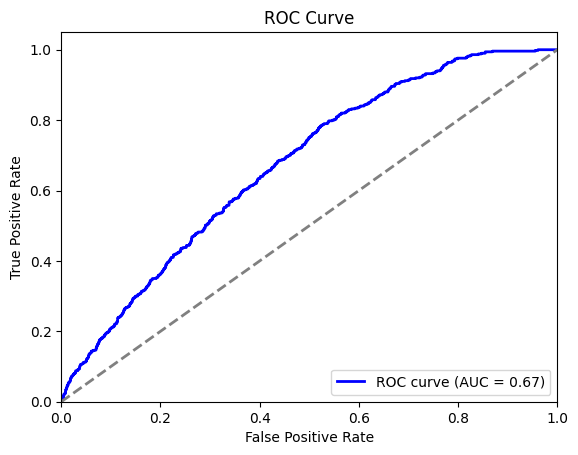

Processing OOD data: 100%|███████████████████████████████████████████████████████████████| 8/8 [00:15<00:00,  2.00s/it]

FPR at TPR=0.05: 0.0040
FPR at TPR=0.15: 0.0196
FPR at TPR=0.25: 0.0423
FPR at TPR=0.35: 0.0680
FPR at TPR=0.45: 0.1094
FPR at TPR=0.55: 0.1714
FPR at TPR=0.65: 0.2349
FPR at TPR=0.75: 0.3322
FPR at TPR=0.85: 0.4253
FPR at TPR=0.95: 0.5781


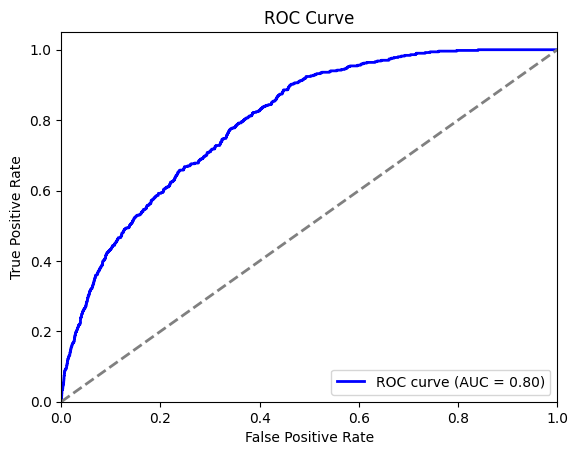

KeyError: 'fpr'

<Figure size 1000x600 with 0 Axes>

In [37]:
softmax_results

{5: {0.05: 0.05,
  0.15000000000000002: 0.11,
  0.25000000000000006: 0.192,
  0.35000000000000003: 0.284,
  0.45000000000000007: 0.374,
  0.5500000000000002: 0.482,
  0.6500000000000001: 0.568,
  0.7500000000000002: 0.684,
  0.8500000000000002: 0.812,
  0.9500000000000002: 0.924},
 15: {0.05: 0.017333333333333333,
  0.15000000000000002: 0.06,
  0.25000000000000006: 0.104,
  0.35000000000000003: 0.17066666666666666,
  0.45000000000000007: 0.23066666666666666,
  0.5500000000000002: 0.30733333333333335,
  0.6500000000000001: 0.38266666666666665,
  0.7500000000000002: 0.4826666666666667,
  0.8500000000000002: 0.592,
  0.9500000000000002: 0.734},
 25: {0.05: 0.0084,
  0.15000000000000002: 0.0388,
  0.25000000000000006: 0.0688,
  0.35000000000000003: 0.1164,
  0.45000000000000007: 0.1676,
  0.5500000000000002: 0.2304,
  0.6500000000000001: 0.2972,
  0.7500000000000002: 0.3864,
  0.8500000000000002: 0.4852,
  0.9500000000000002: 0.6444},
 35: {0.05: 0.008,
  0.15000000000000002: 0.02971428571

In [38]:
knn_results

{5: {0.05: 0.004,
  0.15000000000000002: 0.028,
  0.25000000000000006: 0.09,
  0.35000000000000003: 0.146,
  0.45000000000000007: 0.228,
  0.5500000000000002: 0.318,
  0.6500000000000001: 0.436,
  0.7500000000000002: 0.526,
  0.8500000000000002: 0.642,
  0.9500000000000002: 0.792},
 15: {0.05: 0.016666666666666666,
  0.15000000000000002: 0.03866666666666667,
  0.25000000000000006: 0.072,
  0.35000000000000003: 0.10466666666666667,
  0.45000000000000007: 0.14733333333333334,
  0.5500000000000002: 0.2,
  0.6500000000000001: 0.2793333333333333,
  0.7500000000000002: 0.388,
  0.8500000000000002: 0.51,
  0.9500000000000002: 0.7366666666666667},
 25: {0.05: 0.0156,
  0.15000000000000002: 0.0448,
  0.25000000000000006: 0.086,
  0.35000000000000003: 0.1228,
  0.45000000000000007: 0.1616,
  0.5500000000000002: 0.2236,
  0.6500000000000001: 0.2856,
  0.7500000000000002: 0.366,
  0.8500000000000002: 0.47,
  0.9500000000000002: 0.6496},
 35: {0.05: 0.021714285714285714,
  0.15000000000000002: 0.05

In [45]:
softmax_results_subclass = {
    5: {
        0.05: 0.0180, 0.15: 0.0520, 0.25: 0.1020, 0.35: 0.1420, 0.45: 0.2120, 
        0.55: 0.2620, 0.65: 0.3580, 0.75: 0.4660, 0.85: 0.5780, 0.95: 0.7400
    },
    15: {
        0.05: 0.0100, 0.15: 0.0507, 0.25: 0.0953, 0.35: 0.1433, 0.45: 0.1940, 
        0.55: 0.2560, 0.65: 0.3233, 0.75: 0.4120, 0.85: 0.5213, 0.95: 0.6993
    },
    25: {
        0.05: 0.0096, 0.15: 0.0424, 0.25: 0.0780, 0.35: 0.1252, 0.45: 0.1736, 
        0.55: 0.2264, 0.65: 0.2848, 0.75: 0.3592, 0.85: 0.4640, 0.95: 0.6464
    },
    35: {
        0.05: 0.0117, 0.15: 0.0491, 0.25: 0.0846, 0.35: 0.1351, 0.45: 0.1871, 
        0.55: 0.2489, 0.65: 0.3074, 0.75: 0.3891, 0.85: 0.4971, 0.95: 0.6869
    },
    45: {
        0.05: 0.0131, 0.15: 0.0480, 0.25: 0.0922, 0.35: 0.1498, 0.45: 0.2082, 
        0.55: 0.2671, 0.65: 0.3373, 0.75: 0.4191, 0.85: 0.5204, 0.95: 0.7044
    },
    55: {
        0.05: 0.0160, 0.15: 0.0562, 0.25: 0.1047, 0.35: 0.1525, 0.45: 0.2107, 
        0.55: 0.2642, 0.65: 0.3362, 0.75: 0.4184, 0.85: 0.5235, 0.95: 0.7051
    },
    65: {
        0.05: 0.0132, 0.15: 0.0468, 0.25: 0.0940, 0.35: 0.1440, 0.45: 0.2032, 
        0.55: 0.2648, 0.65: 0.3405, 0.75: 0.4097, 0.85: 0.5228, 0.95: 0.7100
    },
    75: {
        0.05: 0.0115, 0.15: 0.0489, 0.25: 0.0909, 0.35: 0.1372, 0.45: 0.1900, 
        0.55: 0.2505, 0.65: 0.3177, 0.75: 0.4089, 0.85: 0.5045, 0.95: 0.6669
    },
    85: {
        0.05: 0.0178, 0.15: 0.0531, 0.25: 0.0921, 0.35: 0.1341, 0.45: 0.1893, 
        0.55: 0.2491, 0.65: 0.3189, 0.75: 0.3962, 0.85: 0.4972, 0.95: 0.6608
    },
    95: {
        0.05: 0.0167, 0.15: 0.0553, 0.25: 0.1063, 0.35: 0.1546, 0.45: 0.2003, 
        0.55: 0.2624, 0.65: 0.3445, 0.75: 0.4299, 0.85: 0.5260, 0.95: 0.6772
    }
}


In [40]:
knn_results_subclass = {
    5: {
        0.05: 0.0060, 0.15: 0.0500, 0.25: 0.0920, 0.35: 0.1400, 0.45: 0.1900,
        0.55: 0.2560, 0.65: 0.3420, 0.75: 0.4340, 0.85: 0.6160, 0.95: 0.8020,
    },
    15: {
        0.05: 0.0067, 0.15: 0.0387, 0.25: 0.0820, 0.35: 0.1240, 0.45: 0.1640,
        0.55: 0.2213, 0.65: 0.2900, 0.75: 0.3700, 0.85: 0.4980, 0.95: 0.7133,
    },
    25: {
        0.05: 0.0136, 0.15: 0.0444, 0.25: 0.0828, 0.35: 0.1240, 0.45: 0.1612,
        0.55: 0.2144, 0.65: 0.2744, 0.75: 0.3640, 0.85: 0.4920, 0.95: 0.6972,
    },
    35: {
        0.05: 0.0166, 0.15: 0.0540, 0.25: 0.0871, 0.35: 0.1329, 0.45: 0.1817,
        0.55: 0.2440, 0.65: 0.3103, 0.75: 0.3969, 0.85: 0.5069, 0.95: 0.7163,
    },
    45: {
        0.05: 0.0153, 0.15: 0.0582, 0.25: 0.1042, 0.35: 0.1509, 0.45: 0.2122,
        0.55: 0.2767, 0.65: 0.3469, 0.75: 0.4271, 0.85: 0.5480, 0.95: 0.7478,
    },
    55: {
        0.05: 0.0195, 0.15: 0.0649, 0.25: 0.1149, 0.35: 0.1685, 0.45: 0.2296,
        0.55: 0.3080, 0.65: 0.3778, 0.75: 0.4633, 0.85: 0.5965, 0.95: 0.7747,
    },
    65: {
        0.05: 0.0212, 0.15: 0.0692, 0.25: 0.1220, 0.35: 0.1792, 0.45: 0.2429,
        0.55: 0.3151, 0.65: 0.3906, 0.75: 0.4751, 0.85: 0.6028, 0.95: 0.7671,
    },
    75: {
        0.05: 0.0211, 0.15: 0.0601, 0.25: 0.1087, 0.35: 0.1617, 0.45: 0.2219,
        0.55: 0.2941, 0.65: 0.3775, 0.75: 0.4709, 0.85: 0.5733, 0.95: 0.7560,
    },
    85: {
        0.05: 0.0254, 0.15: 0.0780, 0.25: 0.1375, 0.35: 0.1984, 0.45: 0.2532,
        0.55: 0.3260, 0.65: 0.4018, 0.75: 0.5015, 0.85: 0.6145, 0.95: 0.7635,
    },
    95: {
        0.05: 0.0146, 0.15: 0.0816, 0.25: 0.1456, 0.35: 0.2018, 0.45: 0.2700,
        0.55: 0.3419, 0.65: 0.4232, 0.75: 0.5469, 0.85: 0.6751, 0.95: 0.8461,
    },
}



In [82]:
softmax_results_superclass={
 5: {0.05: 0.0500, 0.15: 0.1100, 0.25: 0.1920, 0.35: 0.2840, 0.45: 0.3740, 0.55: 0.4820, 0.65: 0.5680, 0.75: 0.6840, 0.85: 0.8120, 0.95: 0.9240},
 15: {0.05: 0.0173, 0.15: 0.0600, 0.25: 0.1040, 0.35: 0.1707, 0.45: 0.2307, 0.55: 0.3073, 0.65: 0.3827, 0.75: 0.4827, 0.85: 0.5920, 0.95: 0.7340},
 25: {0.05: 0.0084, 0.15: 0.0388, 0.25: 0.0688, 0.35: 0.1164, 0.45: 0.1676, 0.55: 0.2304, 0.65: 0.2972, 0.75: 0.3864, 0.85: 0.4852, 0.95: 0.6444},
 35: {0.05: 0.0080, 0.15: 0.0297, 0.25: 0.0674, 0.35: 0.1123, 0.45: 0.1549, 0.55: 0.2114, 0.65: 0.2740, 0.75: 0.3477, 0.85: 0.4337, 0.95: 0.5669},
 45: {0.05: 0.0109, 0.15: 0.0331, 0.25: 0.0633, 0.35: 0.0982, 0.45: 0.1429, 0.55: 0.1967, 0.65: 0.2642, 0.75: 0.3389, 0.85: 0.4356, 0.95: 0.5898},
 55: {0.05: 0.0082, 0.15: 0.0355, 0.25: 0.0687, 0.35: 0.1024, 0.45: 0.1493, 0.55: 0.2038, 0.65: 0.2627, 0.75: 0.3347, 0.85: 0.4233, 0.95: 0.6095},
 65: {0.05: 0.0094, 0.15: 0.0322, 0.25: 0.0589, 0.35: 0.0938, 0.45: 0.1403, 0.55: 0.2006, 0.65: 0.2605, 0.75: 0.3380, 0.85: 0.4223, 0.95: 0.5865},
 75: {0.05: 0.0129, 0.15: 0.0439, 0.25: 0.0764, 0.35: 0.1164, 0.45: 0.1712, 0.55: 0.2321, 0.65: 0.2973, 0.75: 0.3844, 0.85: 0.4875, 0.95: 0.6617},
 85: {0.05: 0.0176, 0.15: 0.0544, 0.25: 0.0984, 0.35: 0.1601, 0.45: 0.2244, 0.55: 0.2956, 0.65: 0.3659, 0.75: 0.4562, 0.85: 0.5713, 0.95: 0.7389},
 95: {0.05: 0.0141, 0.15: 0.0705, 0.25: 0.1236, 0.35: 0.1912, 0.45: 0.2608, 0.55: 0.3283, 0.65: 0.4134, 0.75: 0.5009, 0.85: 0.6233, 0.95: 0.7694}
}


In [83]:
knn_results_superclass={
 5: {0.05: 0.0040, 0.15: 0.0280, 0.25: 0.0900, 0.35: 0.1460, 0.45: 0.2280, 0.55: 0.3180, 0.65: 0.4360, 0.75: 0.5260, 0.85: 0.6420, 0.95: 0.7920},
 15: {0.05: 0.0167, 0.15: 0.0387, 0.25: 0.0720, 0.35: 0.1047, 0.45: 0.1473, 0.55: 0.2000, 0.65: 0.2793, 0.75: 0.3880, 0.85: 0.5100, 0.95: 0.7367},
 25: {0.05: 0.0156, 0.15: 0.0448, 0.25: 0.0860, 0.35: 0.1228, 0.45: 0.1616, 0.55: 0.2236, 0.65: 0.2856, 0.75: 0.3660, 0.85: 0.4700, 0.95: 0.6496},
 35: {0.05: 0.0217, 0.15: 0.0531, 0.25: 0.0863, 0.35: 0.1246, 0.45: 0.1703, 0.55: 0.2211, 0.65: 0.2686, 0.75: 0.3403, 0.85: 0.4566, 0.95: 0.6343},
 45: {0.05: 0.0131, 0.15: 0.0427, 0.25: 0.0736, 0.35: 0.1149, 0.45: 0.1547, 0.55: 0.1973, 0.65: 0.2504, 0.75: 0.3233, 0.85: 0.4351, 0.95: 0.6127},
 55: {0.05: 0.0211, 0.15: 0.0553, 0.25: 0.0853, 0.35: 0.1185, 0.45: 0.1575, 0.55: 0.2027, 0.65: 0.2558, 0.75: 0.3198, 0.85: 0.4076, 0.95: 0.5664},
 65: {0.05: 0.0148, 0.15: 0.0397, 0.25: 0.0672, 0.35: 0.0991, 0.45: 0.1332, 0.55: 0.1729, 0.65: 0.2240, 0.75: 0.2900, 0.85: 0.3702, 0.95: 0.5326},
 75: {0.05: 0.0157, 0.15: 0.0464, 0.25: 0.0808, 0.35: 0.1197, 0.45: 0.1651, 0.55: 0.2175, 0.65: 0.2691, 0.75: 0.3388, 0.85: 0.4227, 0.95: 0.5819},
 85: {0.05: 0.0193, 0.15: 0.0586, 0.25: 0.0984, 0.35: 0.1498, 0.45: 0.1932, 0.55: 0.2491, 0.65: 0.3235, 0.75: 0.4089, 0.85: 0.5151, 0.95: 0.6865},
 95: {0.05: 0.0040, 0.15: 0.0196, 0.25: 0.0423, 0.35: 0.0680, 0.45: 0.1094, 0.55: 0.1714, 0.65: 0.2349, 0.75: 0.3322, 0.85: 0.4253, 0.95: 0.5781}}


In [44]:
softmax_results_superclass

{5: {0.05: 0.05,
  0.15000000000000002: 0.11,
  0.25000000000000006: 0.192,
  0.35000000000000003: 0.284,
  0.45000000000000007: 0.374,
  0.5500000000000002: 0.482,
  0.6500000000000001: 0.568,
  0.7500000000000002: 0.684,
  0.8500000000000002: 0.812,
  0.9500000000000002: 0.924},
 15: {0.05: 0.017333333333333333,
  0.15000000000000002: 0.06,
  0.25000000000000006: 0.104,
  0.35000000000000003: 0.17066666666666666,
  0.45000000000000007: 0.23066666666666666,
  0.5500000000000002: 0.30733333333333335,
  0.6500000000000001: 0.38266666666666665,
  0.7500000000000002: 0.4826666666666667,
  0.8500000000000002: 0.592,
  0.9500000000000002: 0.734},
 25: {0.05: 0.0084,
  0.15000000000000002: 0.0388,
  0.25000000000000006: 0.0688,
  0.35000000000000003: 0.1164,
  0.45000000000000007: 0.1676,
  0.5500000000000002: 0.2304,
  0.6500000000000001: 0.2972,
  0.7500000000000002: 0.3864,
  0.8500000000000002: 0.4852,
  0.9500000000000002: 0.6444},
 35: {0.05: 0.008,
  0.15000000000000002: 0.02971428571

In [46]:
knn_results_superclass

{5: {0.05: 0.004,
  0.15000000000000002: 0.028,
  0.25000000000000006: 0.09,
  0.35000000000000003: 0.146,
  0.45000000000000007: 0.228,
  0.5500000000000002: 0.318,
  0.6500000000000001: 0.436,
  0.7500000000000002: 0.526,
  0.8500000000000002: 0.642,
  0.9500000000000002: 0.792},
 15: {0.05: 0.016666666666666666,
  0.15000000000000002: 0.03866666666666667,
  0.25000000000000006: 0.072,
  0.35000000000000003: 0.10466666666666667,
  0.45000000000000007: 0.14733333333333334,
  0.5500000000000002: 0.2,
  0.6500000000000001: 0.2793333333333333,
  0.7500000000000002: 0.388,
  0.8500000000000002: 0.51,
  0.9500000000000002: 0.7366666666666667},
 25: {0.05: 0.0156,
  0.15000000000000002: 0.0448,
  0.25000000000000006: 0.086,
  0.35000000000000003: 0.1228,
  0.45000000000000007: 0.1616,
  0.5500000000000002: 0.2236,
  0.6500000000000001: 0.2856,
  0.7500000000000002: 0.366,
  0.8500000000000002: 0.47,
  0.9500000000000002: 0.6496},
 35: {0.05: 0.021714285714285714,
  0.15000000000000002: 0.05

In [52]:
knn_results_subclass

{5: {0.05: 0.006,
  0.15: 0.05,
  0.25: 0.092,
  0.35: 0.14,
  0.45: 0.19,
  0.55: 0.256,
  0.65: 0.342,
  0.75: 0.434,
  0.85: 0.616,
  0.95: 0.802},
 15: {0.05: 0.0057,
  0.15: 0.0453,
  0.25: 0.0867,
  0.35: 0.134,
  0.45: 0.1813,
  0.55: 0.2453,
  0.65: 0.3273,
  0.75: 0.4193,
  0.85: 0.602,
  0.95: 0.7907},
 25: {0.05: 0.0053,
  0.15: 0.0427,
  0.25: 0.0827,
  0.35: 0.1293,
  0.45: 0.1767,
  0.55: 0.2387,
  0.65: 0.322,
  0.75: 0.412,
  0.85: 0.5967,
  0.95: 0.784},
 35: {0.05: 0.005,
  0.15: 0.0407,
  0.25: 0.0787,
  0.35: 0.1247,
  0.45: 0.1727,
  0.55: 0.234,
  0.65: 0.318,
  0.75: 0.4087,
  0.85: 0.59,
  0.95: 0.7773},
 45: {0.05: 0.0047,
  0.15: 0.0393,
  0.25: 0.076,
  0.35: 0.1213,
  0.45: 0.1673,
  0.55: 0.23,
  0.65: 0.314,
  0.75: 0.4053,
  0.85: 0.586,
  0.95: 0.7733},
 55: {0.05: 0.0043,
  0.15: 0.0373,
  0.25: 0.0733,
  0.35: 0.1173,
  0.45: 0.164,
  0.55: 0.226,
  0.65: 0.31,
  0.75: 0.402,
  0.85: 0.582,
  0.95: 0.77},
 65: {0.05: 0.004,
  0.15: 0.0353,
  0.25: 0.07

C:\Users\Zhao\AppData\Local\Temp\ipykernel_1916\4173566397.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', 10)


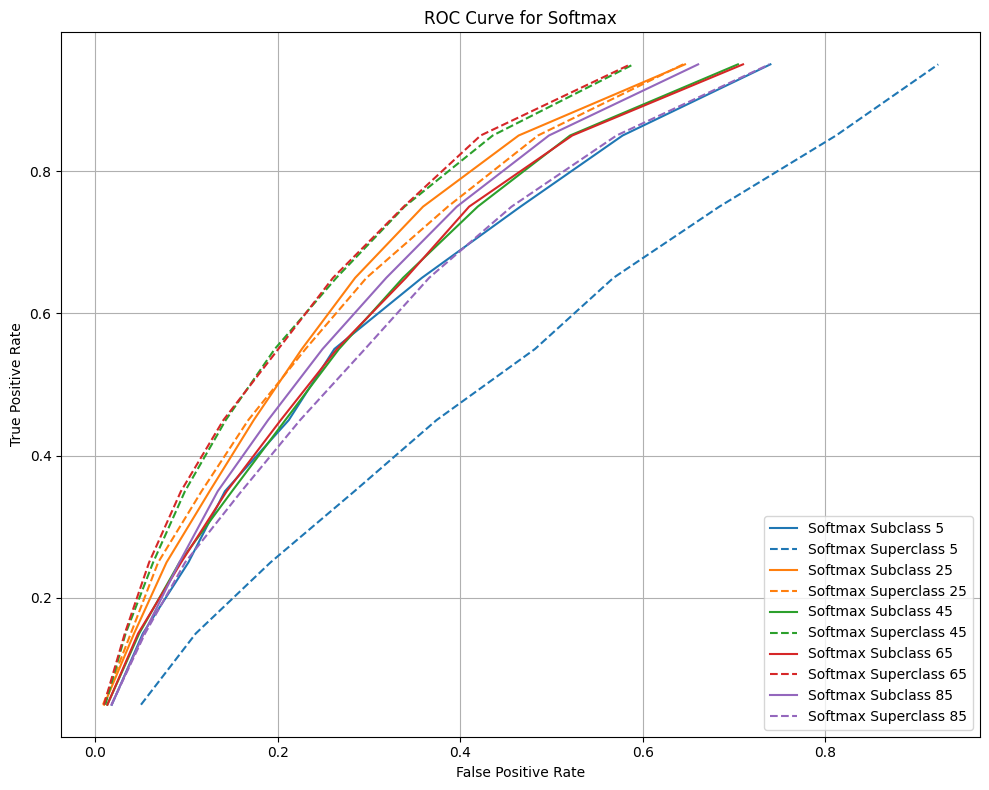

In [86]:
def plot_roc_softmax(softmax_results_subclass, softmax_results_superclass):
    plt.figure(figsize=(10, 8))

    # Set a set of 10 distinct colors for the lines
    colors = plt.cm.get_cmap('tab10', 10)

    # List of class numbers to plot
    class_numbers_to_plot = [5, 25, 45, 65, 85]

    # Plot the ROC curves for Softmax Subclass and Superclass for selected class numbers
    for i, key in enumerate(class_numbers_to_plot):
        # Select a color from the colormap for this class number
        color = colors(i)
        
        # Swap the x and y axes by switching key and values
        # Plot Softmax Subclass (solid line) with the same color for each class
        plt.plot(list(softmax_results_subclass[key].values()), list(softmax_results_subclass[key].keys()), label=f'Softmax Subclass {key}', linestyle='-', color=color)
        
        # Plot Softmax Superclass (dashed line) with the same color for each class
        plt.plot(list(softmax_results_superclass[key].values()), list(softmax_results_superclass[key].keys()), label=f'Softmax Superclass {key}', linestyle='--', color=color)

    # Switch x and y axes by inverting the labels
    plt.title('ROC Curve for Softmax')
    plt.xlabel('False Positive Rate')  # x-axis will represent TPR
    plt.ylabel('True Positive Rate')  # y-axis will represent FPR
    
    plt.legend(loc='lower right')
    
    # Show grid for better readability
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_roc_softmax(softmax_results_subclass, softmax_results_superclass)


C:\Users\Zhao\AppData\Local\Temp\ipykernel_1916\478851902.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', 10)


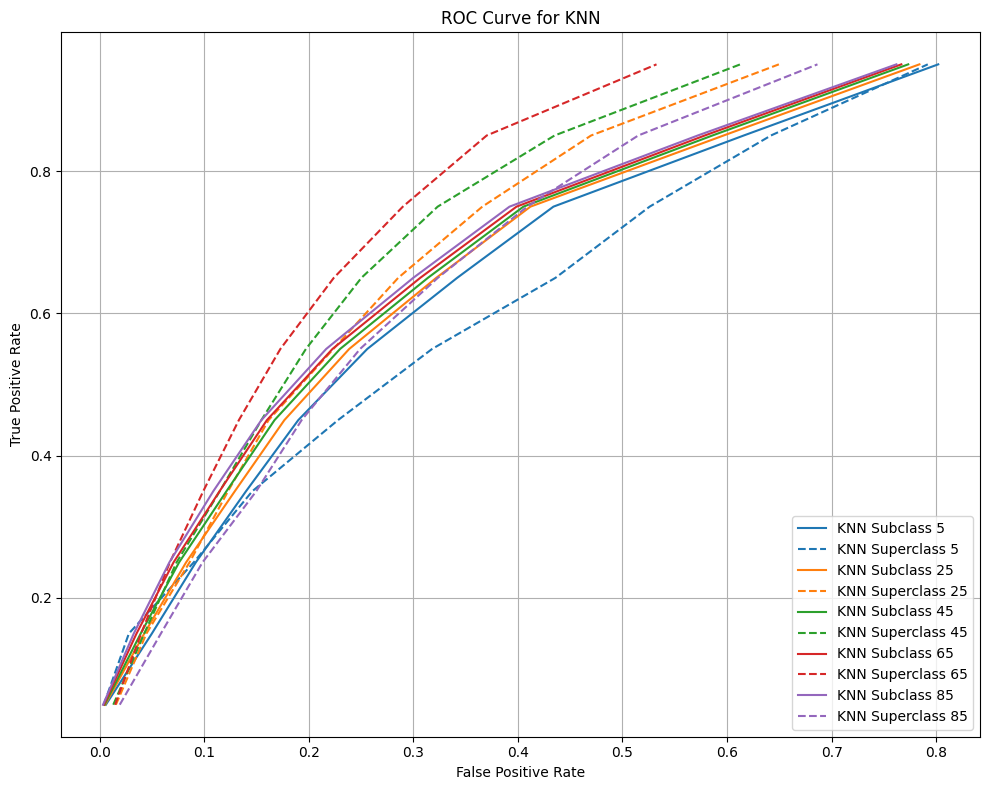

In [87]:
def plot_roc_knn(knn_results_subclass, knn_results_superclass):
    plt.figure(figsize=(10, 8))

    # Set a set of 10 distinct colors for the lines
    colors = plt.cm.get_cmap('tab10', 10)

    # List of class numbers to plot
    class_numbers_to_plot = [5, 25, 45, 65, 85]

    # Plot the ROC curves for KNN Subclass and Superclass for selected class numbers
    for i, key in enumerate(class_numbers_to_plot):
        # Select a color from the colormap for this class number
        color = colors(i)
        
        # Plot KNN Subclass (solid line) with the same color for each class
        plt.plot(list(knn_results_subclass[key].values()), list(knn_results_subclass[key].keys()), label=f'KNN Subclass {key}', linestyle='-', color=color)
        
        # Plot KNN Superclass (dashed line) with the same color for each class
        plt.plot(list(knn_results_superclass[key].values()), list(knn_results_superclass[key].keys()), label=f'KNN Superclass {key}', linestyle='--', color=color)

    plt.title('ROC Curve for KNN')
    plt.xlabel('False Positive Rate')  # x-axis will represent FPR
    plt.ylabel('True Positive Rate')  # y-axis will represent TPR
    
    plt.legend(loc='lower right')
    
    # Show grid for better readability
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_roc_knn(knn_results_subclass, knn_results_superclass)


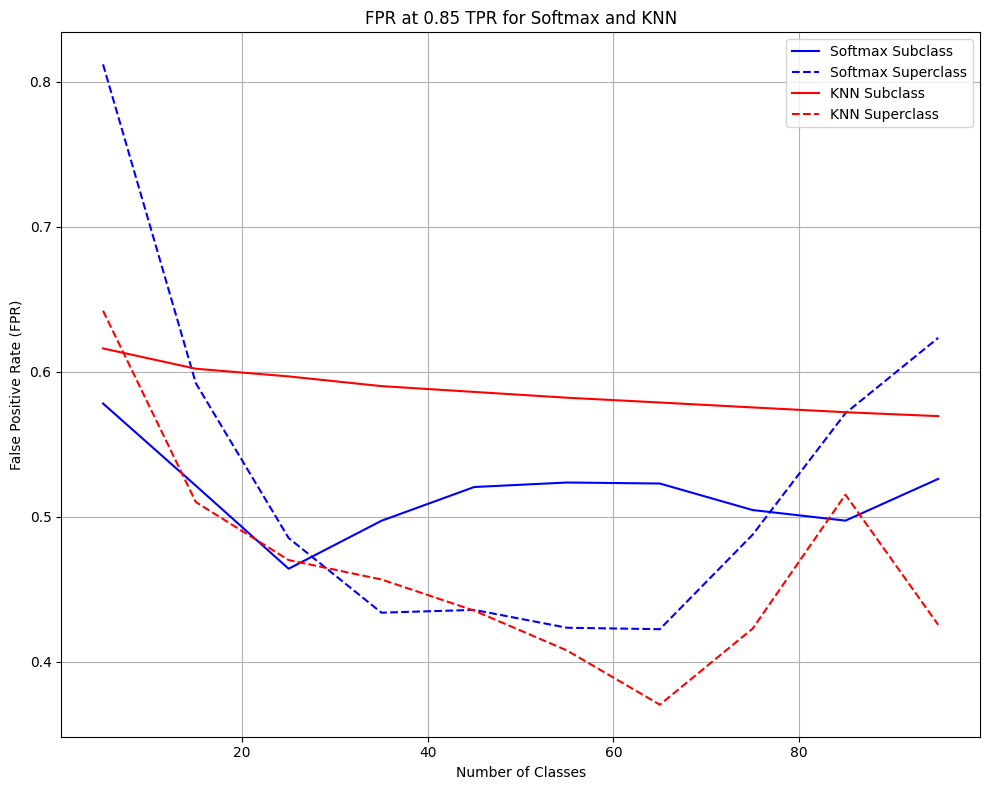

In [92]:
def plot_fpr_at_x_tpr(x, softmax_results_subclass, softmax_results_superclass, knn_results_subclass, knn_results_superclass):
    # Set the number of classes to be plotted on the x-axis (from 5 to 95, inclusive)
    class_numbers = list(range(5, 96, 10))  # Creates [5, 15, 25, ..., 95]
    
    # Extract FPR at 80% TPR for each class and method (Softmax and KNN)
    fpr_softmax_subclass = []
    fpr_softmax_superclass = []
    fpr_knn_subclass = []
    fpr_knn_superclass = []
    
    for key in class_numbers:
       
        tpr = x
        
        # For Softmax results
        fpr_softmax_subclass.append(softmax_results_subclass[key].get(tpr, None))
        fpr_softmax_superclass.append(softmax_results_superclass[key].get(tpr, None))
        
        # For KNN results
        fpr_knn_subclass.append(knn_results_subclass[key].get(tpr, None))
        fpr_knn_superclass.append(knn_results_superclass[key].get(tpr, None))

    # Plot the FPR vs number of classes for each method
    plt.figure(figsize=(10, 8))

    plt.plot(class_numbers, fpr_softmax_subclass, label='Softmax Subclass', linestyle='-', color='b')
    plt.plot(class_numbers, fpr_softmax_superclass, label='Softmax Superclass', linestyle='--', color='b')
    plt.plot(class_numbers, fpr_knn_subclass, label='KNN Subclass', linestyle='-', color='r')
    plt.plot(class_numbers, fpr_knn_superclass, label='KNN Superclass', linestyle='--', color='r')

    # Labels and title
    plt.title(f'FPR at {x} TPR for Softmax and KNN')
    plt.xlabel('Number of Classes')
    plt.ylabel('False Positive Rate (FPR)')

    # Show grid and legend
    plt.grid(True)
    plt.legend(loc='upper right')

    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage:
plot_fpr_at_x_tpr(0.85,softmax_results_subclass, softmax_results_superclass, knn_results_subclass, knn_results_superclass)


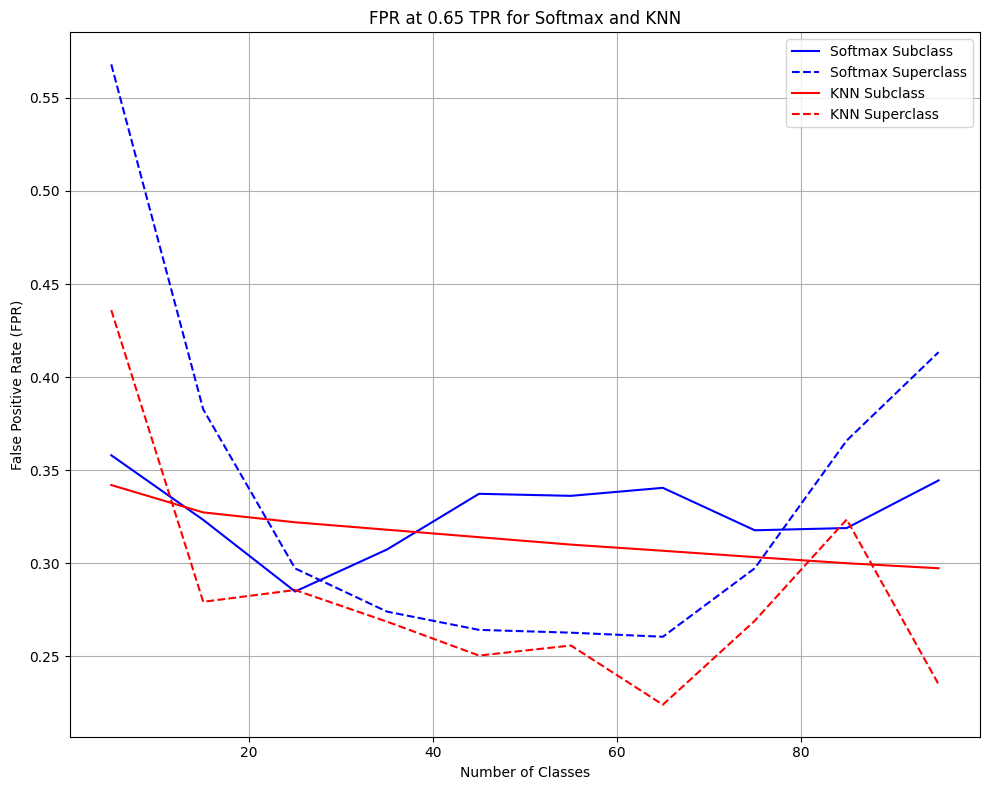

In [93]:
plot_fpr_at_x_tpr(0.65,softmax_results_subclass, softmax_results_superclass, knn_results_subclass, knn_results_superclass)